In [3]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
from datetime import datetime
from tabulate import tabulate
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
import concurrent.futures
import multiprocessing
import logging
from sklearn.ensemble import RandomForestClassifier
from docx import Document
import json
import os
from io import BytesIO
import copy

In [9]:
def select_features_rf(X, y, num_features=10):
    model = RandomForestClassifier()
    model.fit(X, y)
    feature_importances = model.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:]
    return selected_features

In [10]:
def fast_non_dominated_sort( population):
        fronts = [[]]
        for p in population:
            p.domination_count = 0
            p.dominated_solutions = set()

            for q in population:
                if p.dominate(q):
                    p.dominated_solutions.add(q)
                elif q.dominate(p):
                    p.domination_count += 1

            if p.domination_count == 0:
                p.rank = 0
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = i + 1
                        next_front.append(q)

            i += 1
            fronts.append(next_front)
        return fronts


In [11]:
# for sure values are not correct
def create_chromosome(row, num_features):
    values = np.random.randint(2, size=num_features)
    chromosome = Chromosome(values)
    chromosome.objectives = [row['Classification-error'], row['Solution-size']]
    return chromosome

In [12]:
def calc_true_pareto_front(U_PF_dataset_path, num_features):
    df = pd.read_csv(U_PF_dataset_path)
    population = df.apply(lambda row: create_chromosome(row, num_features), axis=1)
    fronts = fast_non_dominated_sort(population)
    objectives = [chromosome.objectives for chromosome in fronts[0]]
    return objectives

In [22]:
json_string = '''{
    "DS02.csv": {
      "num_objectives": 2,
      "population_size": 100,
      "Q": 5,
      "LP": 5,
      "igd_threshold": 0.005,
      "hv_threshold": 0.1,
      "no_improvement_limit": 30,
      "maxFEs": 10000
    },
    "DS04.csv": {
      "num_objectives": 2,
      "population_size": 100,
      "Q": 5,
      "LP": 5,
      "igd_threshold": 0.05,
      "hv_threshold": 0.1,
      "no_improvement_limit": 30,
      "maxFEs": 20000
    },
    "DS05.csv": {
      "num_objectives": 2,
      "population_size": 100,
      "Q": 5,
      "LP": 5,
      "igd_threshold": 0.1,
      "hv_threshold": 1,
      "no_improvement_limit": 30,
      "maxFEs": 30000
    },
    "DS07.csv": {
      "num_objectives": 2,
      "population_size": 100,
      "Q": 5,
      "LP": 5,
      "igd_threshold": 0.1,
      "hv_threshold": 0.5,
      "no_improvement_limit": 40,
      "maxFEs": 40000
    },
    "DS08.csv": {
      "num_objectives": 2,
      "population_size": 100,
      "Q": 5,
      "LP": 5,
      "igd_threshold": 0.5,
      "hv_threshold": 1,
      "no_improvement_limit": 70,
      "maxFEs": 40000
    },
    "DS10.csv": {
      "num_objectives": 2,
      "population_size": 100,
      "Q": 5,
      "LP": 5,
      "igd_threshold": 0.05,
      "hv_threshold": 0.5,
      "no_improvement_limit": 30,
      "maxFEs": 30000
    }
  
}
'''

In [14]:
def run_nsga_on_dataset(dataset_name):
    num_objectives = 2
    dataset_path = "../input/mobga-aos/" + dataset_name
    dp = DataProcessor(dataset_path)
    dp.load_data()
    config_file_path = "../input/configuration/config.json"
    config_data = json.loads(json_string)
    config = NSGAConfig(config_file_path)
    config.config_data = config_data
#     config = NSGAConfig(config_file_path)
    population_size, Q, LP, igd_threshold, hv_threshold, no_improvement_limit, maxFEs = config.get_parameters(dataset_name)
    y = np.array(dp.dataset["LABEL"])
    X = np.array(dp.dataset.drop("LABEL", axis=1, inplace=False))
    selected_features = select_features_rf(X, y, num_features=100)    
    num_features = dp.num_features()
    U_PF_dataset_path = "../input/union-pareto/"+ dataset_name
    true_pareto_front = calc_true_pareto_front(U_PF_dataset_path, num_features)    
    print("number of features: ", num_features)
   
    nsga2 = NSGAII(X, y, population_size, LP, num_features, true_pareto_front, selected_features, maxFEs, no_improvement_limit, igd_threshold, hv_threshold)
    current_solutions, igd_values, hypervolume_values = nsga2.nsga2()
    return current_solutions, igd_values, hypervolume_values

In [15]:
def plot_values(dataset_name, current_solutions, igd_values, hypervolume_values):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    x_values = [item.objectives[1] for item in current_solutions]
    y_values = [item.objectives[0] for item in current_solutions]
    plt.scatter(x_values, y_values, marker='o', color='b')
    plt.xlabel('Solution Size')
    plt.ylabel('Classification Error')
    plt.title(f'Final Pareto front for {dataset_name}')

    plt.subplot(1, 3, 2)
    plt.plot(igd_values, color='r', label=f'Mean: {np.mean(igd_values):.2f}\nStd: {np.std(igd_values):.2f}')
    plt.title('IGD')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(hypervolume_values, color='g', label=f'Mean: {np.mean(hypervolume_values):.2f}\nStd: {np.std(hypervolume_values):.2f}')
    plt.title('Hypervolume')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
def run_different_dataset(dataset_name):
    start_time = time.time()
    current_solutions, igd_values, hypervolume_values = run_nsga_on_dataset(dataset_name)
    generations.append(len(igd_values))
    end_time = time.time()
    elapsed_time = end_time - start_time
    duration_minutes = elapsed_time // 60
    elapsed_times.append(duration_minutes)  
    hv_mean.append(np.mean(hypervolume_values))
    igd_mean.append(np.mean(igd_values))
    hv_std.append(np.std(hypervolume_values))
    igd_std.append(np.std(igd_values))
    
    plot_values(dataset_name, current_solutions, igd_values, hypervolume_values)


In [17]:
datasets = ["DS02.csv", "DS04.csv", "DS05.csv" ,"DS07.csv", "DS08.csv", "DS10.csv"]

In [18]:
document_path = "table.docx"
doc = Document()
doc.add_heading('Run Result', 0)
doc.save(document_path)

number of features:  56

Evaluations: 7000, HV: 48.25925925925926, IGD: 0.22258546689283795

No improvement in the last 30 generations. Stopping the algorithm.


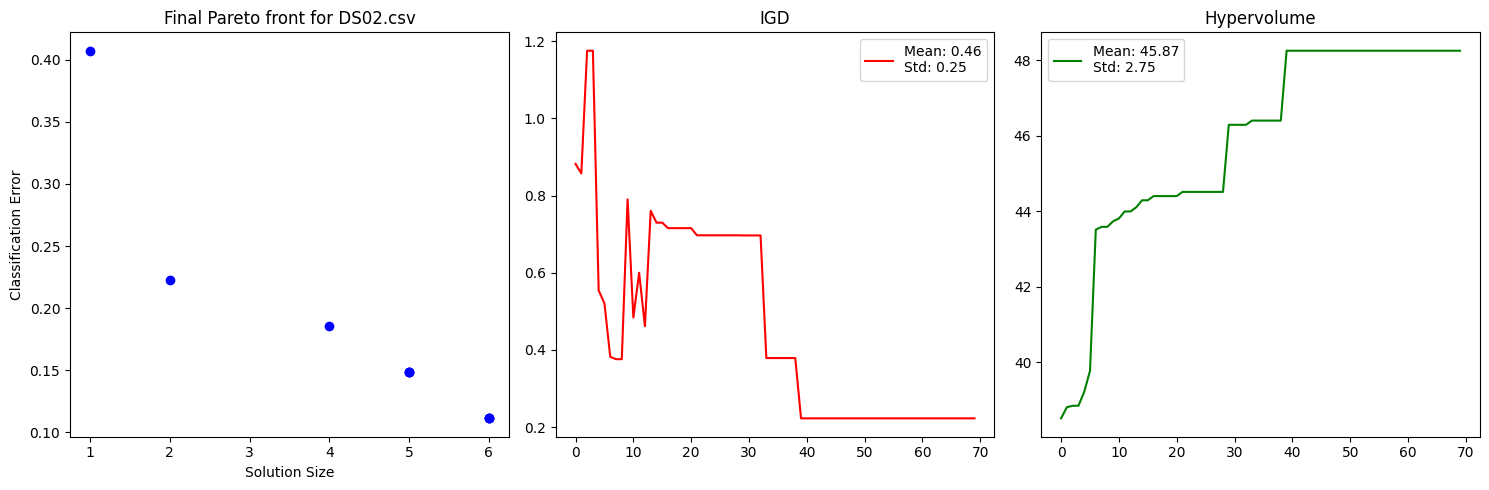

number of features:  56

Evaluations: 5400, HV: 46.4074074074074, IGD: 0.3788426751433336

No improvement in the last 30 generations. Stopping the algorithm.


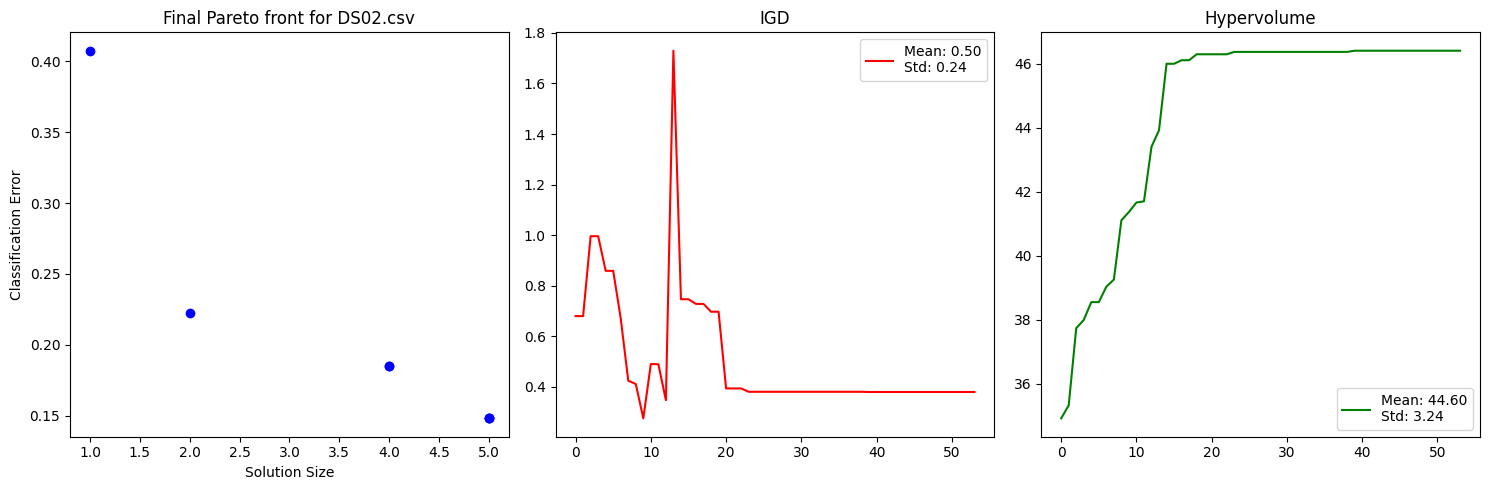

number of features:  56

Evaluations: 8900, HV: 48.25925925925926, IGD: 0.22258546689283795

No improvement in the last 30 generations. Stopping the algorithm.


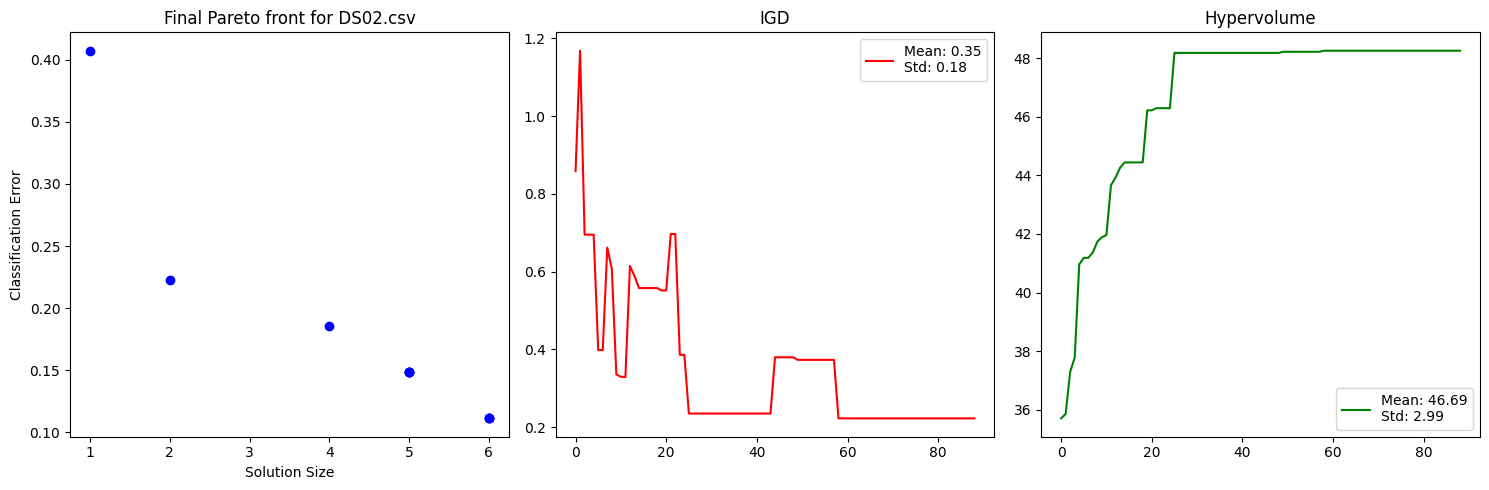

number of features:  56

Evaluations: 8600, HV: 48.25925925925926, IGD: 0.22258546689283795

No improvement in the last 30 generations. Stopping the algorithm.


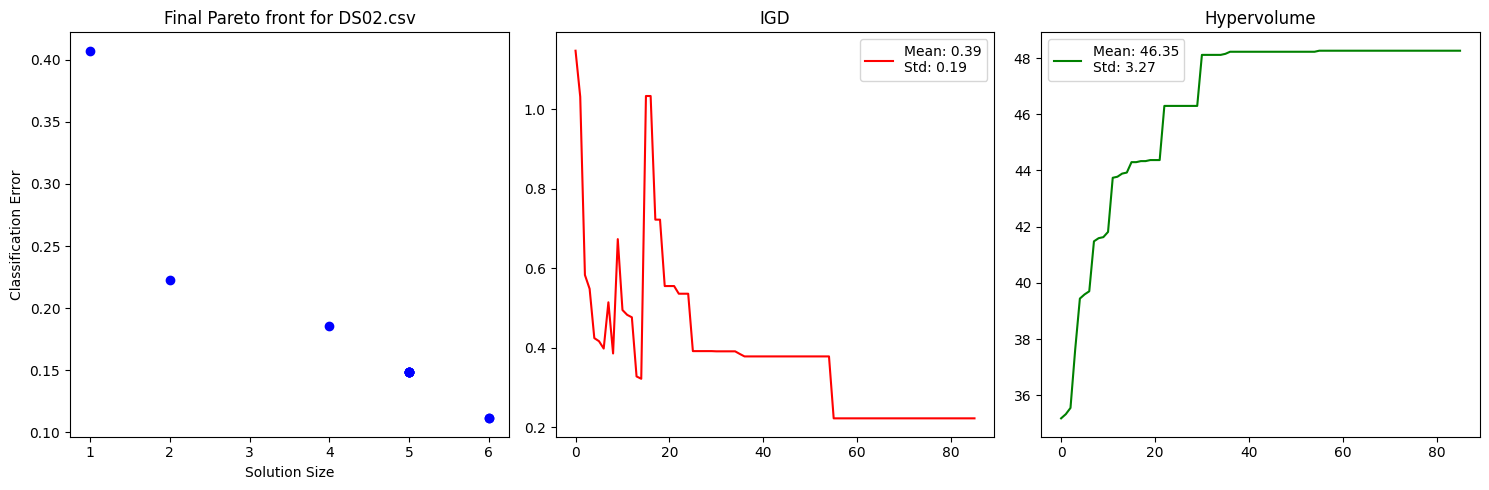

number of features:  56

Evaluations: 6400, HV: 48.14814814814815, IGD: 0.37884267514333353

No improvement in the last 30 generations. Stopping the algorithm.


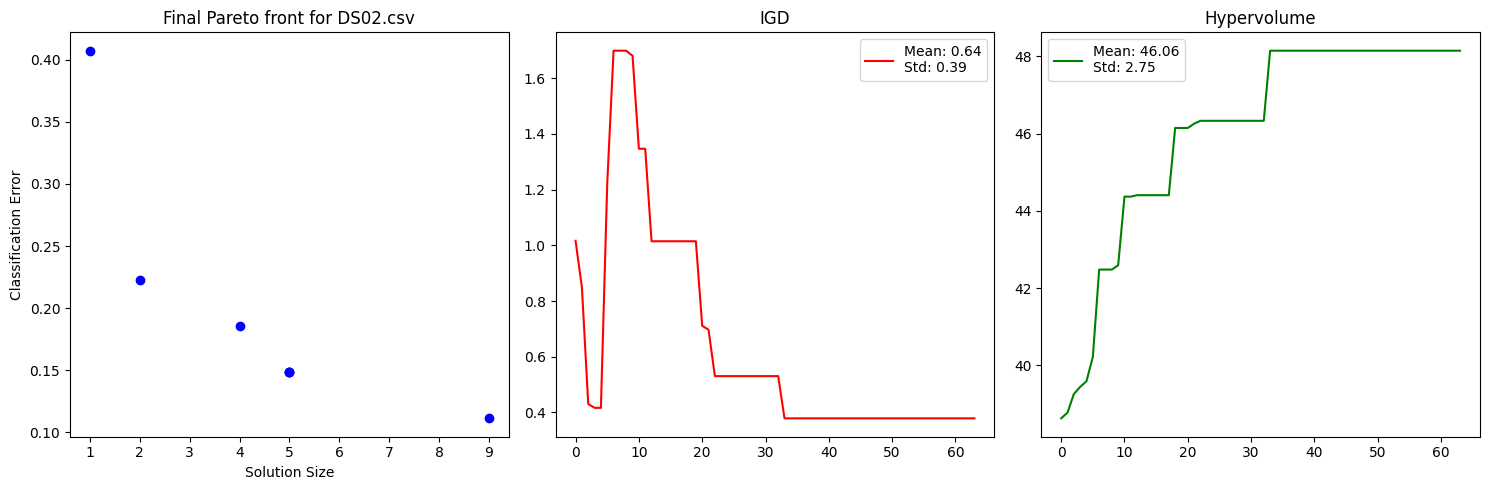

+-----------+---------------+-----------+----------+------------+-----------+------------+

| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |

+===========+===============+===========+==========+============+===========+============+

| DS02.csv  |            70 |   45.8693 |  2.74661 |   0.456694 |  0.254774 |          2 |

+-----------+---------------+-----------+----------+------------+-----------+------------+

| DS02.csv  |            54 |   44.5988 |  3.23781 |   0.503211 |  0.244547 |          1 |

+-----------+---------------+-----------+----------+------------+-----------+------------+

| DS02.csv  |            89 |   46.6866 |  2.99346 |   0.348842 |  0.179997 |          2 |

+-----------+---------------+-----------+----------+------------+-----------+------------+

| DS02.csv  |            86 |   46.3488 |  3.266   |   0.388342 |  0.194258 |          2 |

+-----------+---------------+-----------+----------+------------+-----------+---

In [77]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std  = []
igd_std = []
generations = []
for _ in range(5):
    run_different_dataset(datasets[0])

doc = Document(document_path)
data = list(zip([datasets[0]]*5, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  64

Evaluations: 100000, Hypervolume: 59.31214747681813

Evaluations: 200000, Hypervolume: 59.40911570252888

Evaluations: 300000, Hypervolume: 59.40911570252888


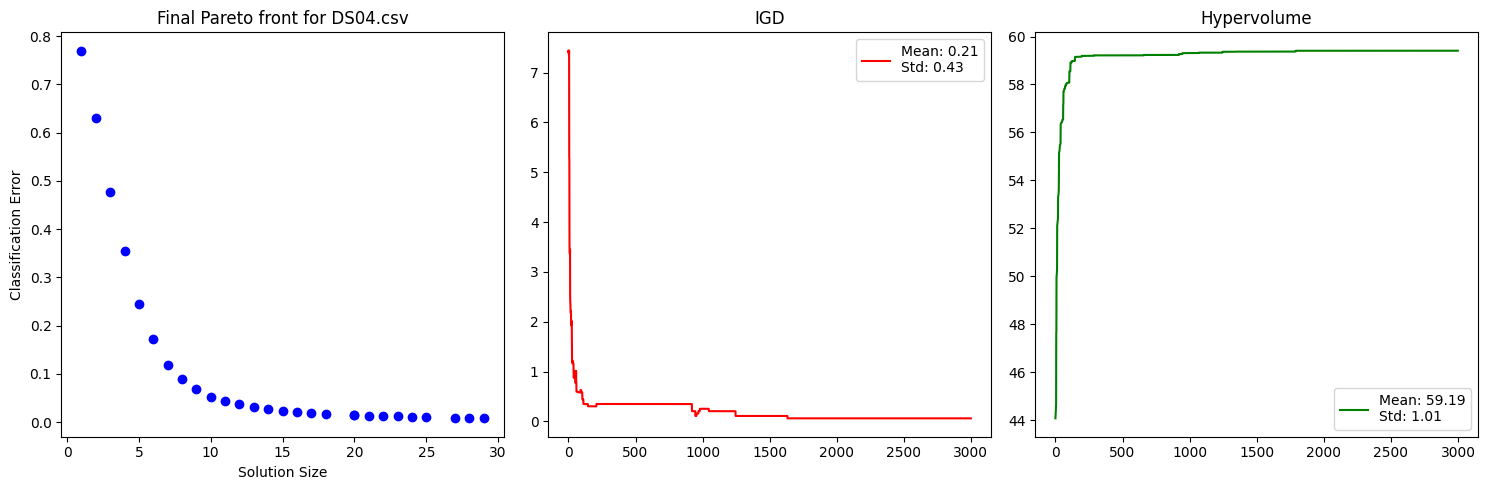

In [36]:
# random initialize
run_different_dataset(datasets[1])

In [41]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []



number of features:  64

Evaluations: 2500, HV: 58.38647030263797, IGD: 0.28224862806395407

Evaluations: 5000, HV: 58.979410548272824, IGD: 0.11905538180767491

Evaluations: 7500, HV: 59.10049870229511, IGD: 0.16253241618914765

Evaluations: 8500, HV: 59.17250184316052, IGD: 0.15914846681250272

No improvement in the last 40 generations. Stopping the algorithm.


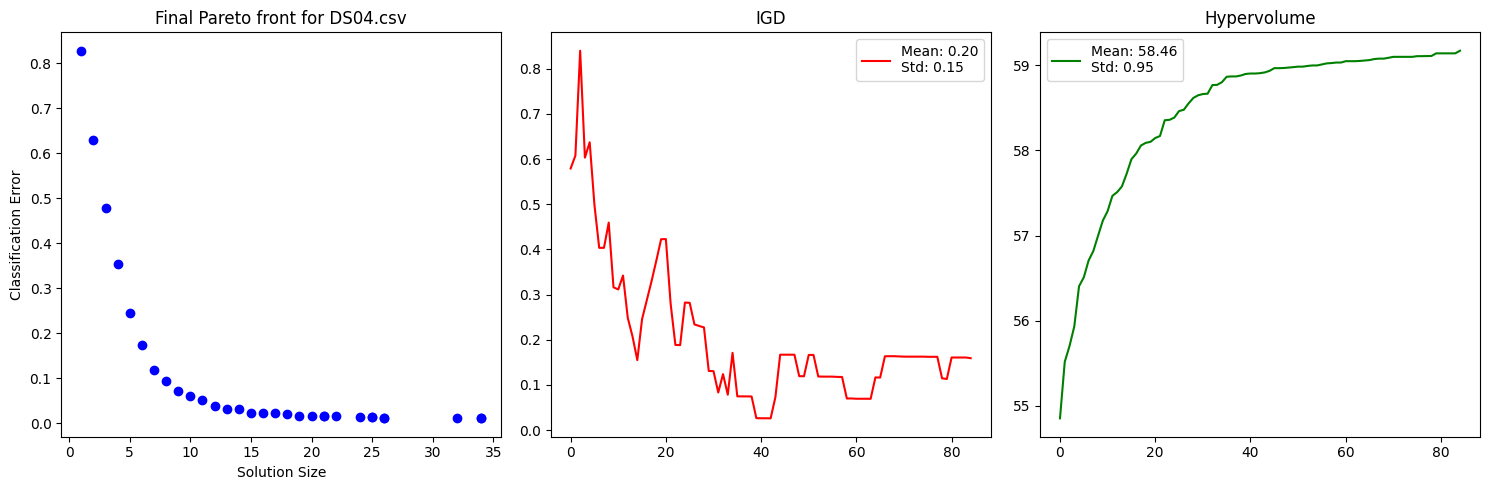

+-----------+---------------+-----------+----------+------------+-----------+------------+

| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |

+===========+===============+===========+==========+============+===========+============+

| DS04      |            85 |    58.465 | 0.945286 |   0.204455 |  0.153442 |         29 |

+-----------+---------------+-----------+----------+------------+-----------+------------+


In [34]:
# wise initialization run 1
run_different_dataset(datasets[1])
doc = Document(document_path)
data = list(zip(["DS04"], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  64

Evaluations: 2500, HV: 58.232418046789306, IGD: 0.287012151307644

Evaluations: 5000, HV: 58.927460394526264, IGD: 0.2153131849334206

Evaluations: 7500, HV: 59.159326991662326, IGD: 0.2075776771132428

Evaluations: 10000, HV: 59.20032008055961, IGD: 0.1112112490840915

No improvement in the last 40 generations. Stopping the algorithm.


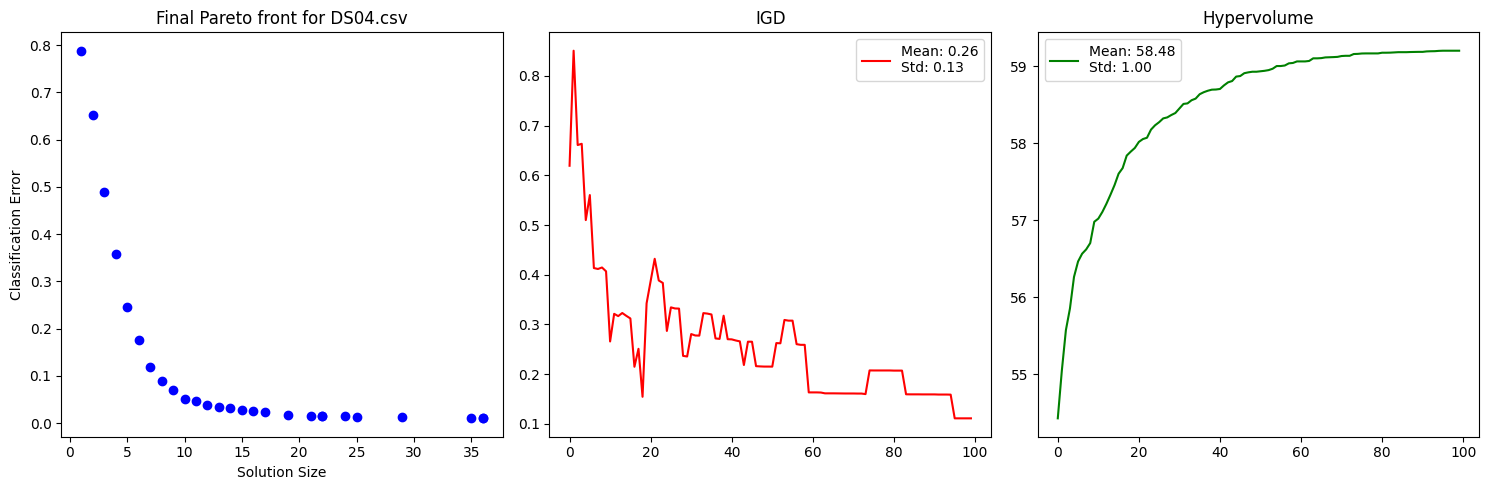

+-----------+---------------+-----------+----------+------------+-----------+------------+

| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |

+===========+===============+===========+==========+============+===========+============+

| DS04      |            85 |   58.465  | 0.945286 |   0.204455 |  0.153442 |         29 |

+-----------+---------------+-----------+----------+------------+-----------+------------+

| DS04      |           100 |   58.4846 | 0.995055 |   0.262293 |  0.12707  |         34 |

+-----------+---------------+-----------+----------+------------+-----------+------------+


In [35]:
# wise initialization run 2
run_different_dataset(datasets[1])
doc = Document(document_path)
data = list(zip(["DS04"]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  64

Evaluations: 2500, HV: 58.29358999718282, IGD: 0.3765366183953595

Evaluations: 5000, HV: 58.903397409385434, IGD: 0.16952166503184735

Evaluations: 7500, HV: 59.087566608524696, IGD: 0.21161677245390076

Evaluations: 10000, HV: 59.148519777262294, IGD: 0.1616097611476406

Evaluations: 12500, HV: 59.2275748802695, IGD: 0.20580537853715106

Evaluations: 15000, HV: 59.245619871368376, IGD: 0.20520121032328104

Evaluations: 16400, HV: 59.24861388334442, IGD: 0.25268613166197906

No improvement in the last 40 generations. Stopping the algorithm.


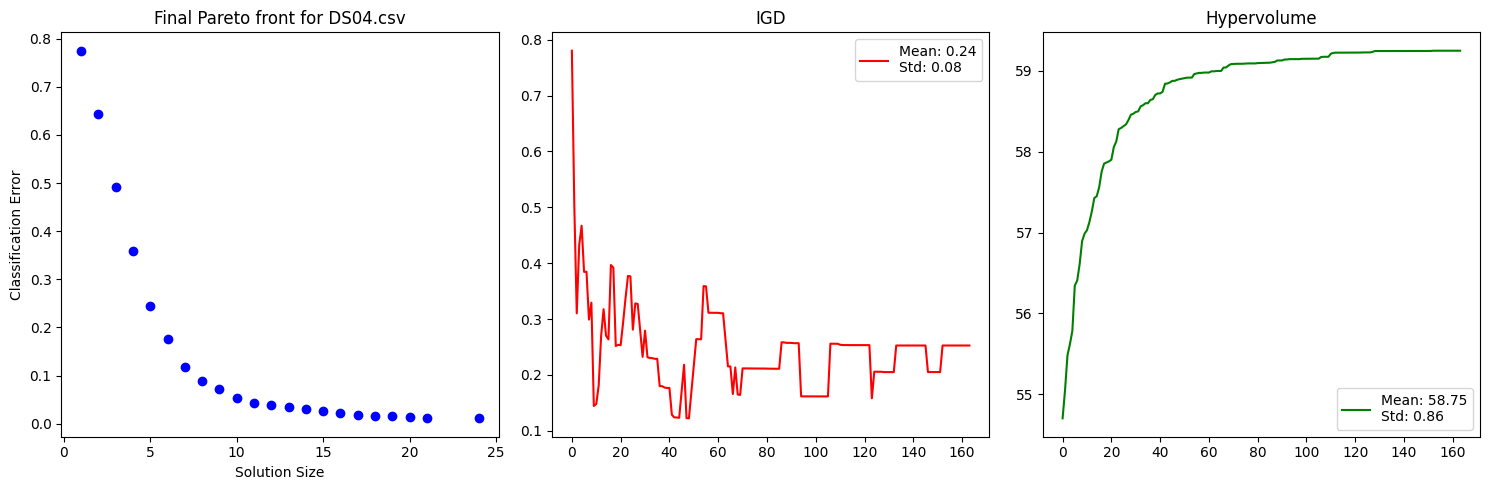

+-----------+---------------+-----------+----------+------------+-----------+------------+

| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |

+===========+===============+===========+==========+============+===========+============+

| DS04      |            85 |   58.465  | 0.945286 |   0.204455 | 0.153442  |         29 |

+-----------+---------------+-----------+----------+------------+-----------+------------+

| DS04      |           100 |   58.4846 | 0.995055 |   0.262293 | 0.12707   |         34 |

+-----------+---------------+-----------+----------+------------+-----------+------------+

| DS04      |           164 |   58.7548 | 0.857002 |   0.244203 | 0.0768767 |         56 |

+-----------+---------------+-----------+----------+------------+-----------+------------+


In [36]:
#wise initialization run 3
run_different_dataset(datasets[1])

doc = Document(document_path)
data = list(zip(["DS04"]*3, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  64
Evaluations: 2500, HV: 58.0483567399735, IGD: 0.2971942676047815
Evaluations: 5000, HV: 58.78056199912487, IGD: 0.1710613727469854
Evaluations: 7500, HV: 59.053553553553556, IGD: 0.11484062971360318
Evaluations: 10000, HV: 59.1394867921814, IGD: 0.15903002454761012
Evaluations: 12500, HV: 59.18841895788003, IGD: 0.0637778942986525
Evaluations: 15000, HV: 59.26847206487925, IGD: 0.20552003582399725
Evaluations: 16100, HV: 59.27949206691722, IGD: 0.25280844165843996
No improvement in the last 40 generations. Stopping the algorithm.


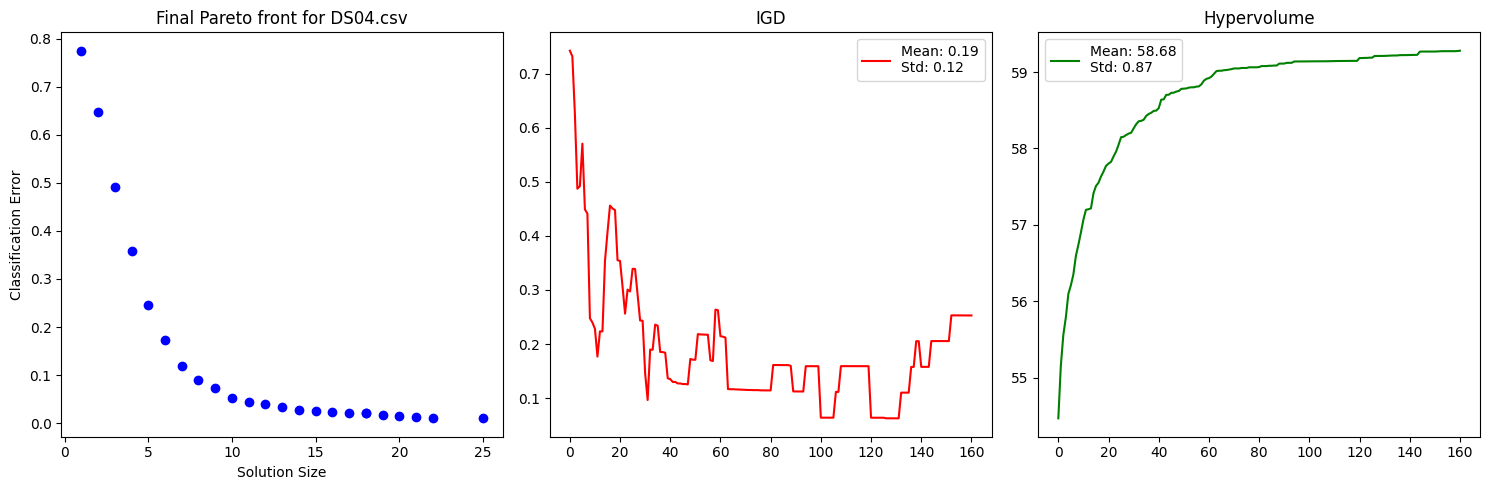

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS04.csv  |           161 |    58.683 |  0.87241 |   0.193206 |  0.118905 |         52 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [42]:
#wise initialization run 4
run_different_dataset(datasets[1])

doc = Document(document_path)
data = list(zip([datasets[1]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  64
Evaluations: 2500, HV: 58.2564660468852, IGD: 0.09338668146199346
Evaluations: 5000, HV: 58.872426318534096, IGD: 0.31213949488514664
Evaluations: 7500, HV: 59.102506698315075, IGD: 0.06526307974986677
Evaluations: 8200, HV: 59.14620009230787, IGD: 0.06492927003481955
No improvement in the last 30 generations. Stopping the algorithm.


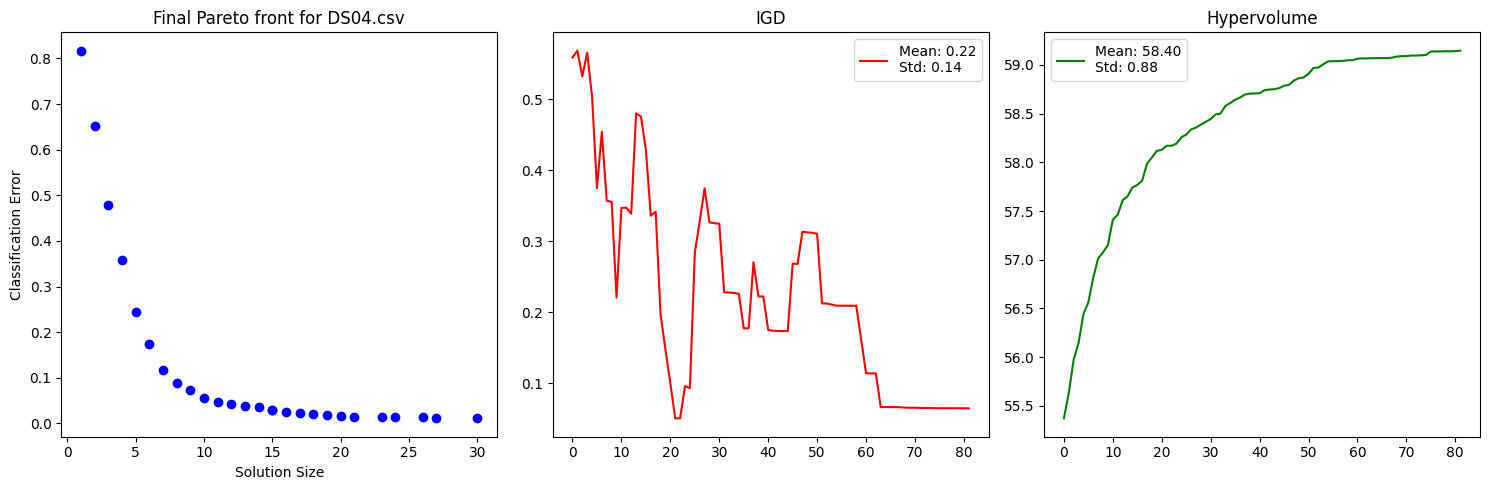

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS04.csv  |           161 |   58.683  | 0.87241  |   0.193206 |  0.118905 |         52 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS04.csv  |            82 |   58.3991 | 0.884551 |   0.223908 |  0.140849 |         28 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [44]:
#wise initialization run 5
run_different_dataset(datasets[1])
doc = Document(document_path)
data = list(zip([datasets[1]]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  64
Evaluations: 2500, HV: 58.2564660468852, IGD: 0.09338668146199346
Evaluations: 5000, HV: 58.872426318534096, IGD: 0.31213949488514664
Evaluations: 7500, HV: 59.102506698315075, IGD: 0.06526307974986677
Evaluations: 8200, HV: 59.14620009230787, IGD: 0.06492927003481955
No improvement in the last 30 generations. Stopping the algorithm.


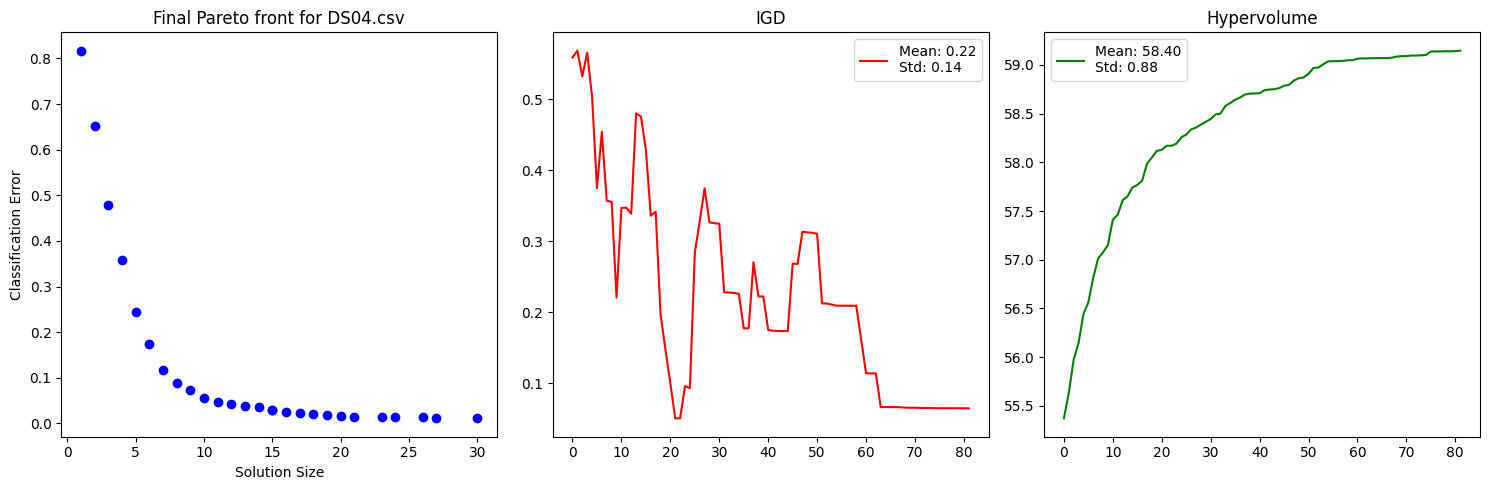

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS04.csv  |           161 |   58.683  | 0.87241  |   0.193206 |  0.118905 |         52 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS04.csv  |            82 |   58.3991 | 0.884551 |   0.223908 |  0.140849 |         28 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [44]:
#wise initialization run 5
run_different_dataset(datasets[1])
doc = Document(document_path)
data = list(zip([datasets[1]]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  500
Evaluations: 2500, HV: 434.09333333333336, IGD: 1.0579036209627934
Evaluations: 5000, HV: 446.49333333333334, IGD: 0.3296338485333777
Evaluations: 7500, HV: 448.975, IGD: 0.47153719021523816
Evaluations: 9100, HV: 448.99666666666667, IGD: 0.47058480926285723
No improvement in the last 25 generations. Stopping the algorithm.


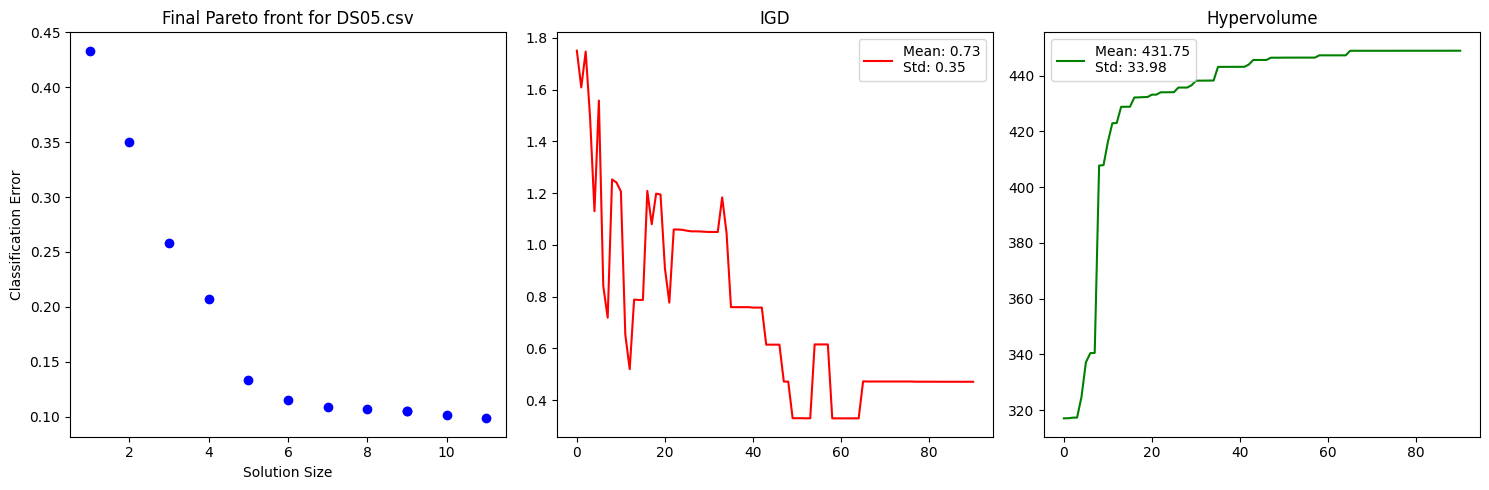

number of features:  500
Evaluations: 2500, HV: 420.90833333333336, IGD: 0.35308615097086565
Evaluations: 5000, HV: 434.99166666666673, IGD: 0.6195863641764378
Evaluations: 7500, HV: 436.6866666666666, IGD: 0.18499175178168006
Evaluations: 10000, HV: 441.6133333333334, IGD: 0.465730790902865
Evaluations: 12500, HV: 446.53499999999997, IGD: 0.03911957142857148
Evaluations: 15000, HV: 448.1616666666667, IGD: 0.17987341132985532
Evaluations: 16200, HV: 449.78166666666664, IGD: 0.17987341132985532
No improvement in the last 25 generations. Stopping the algorithm.


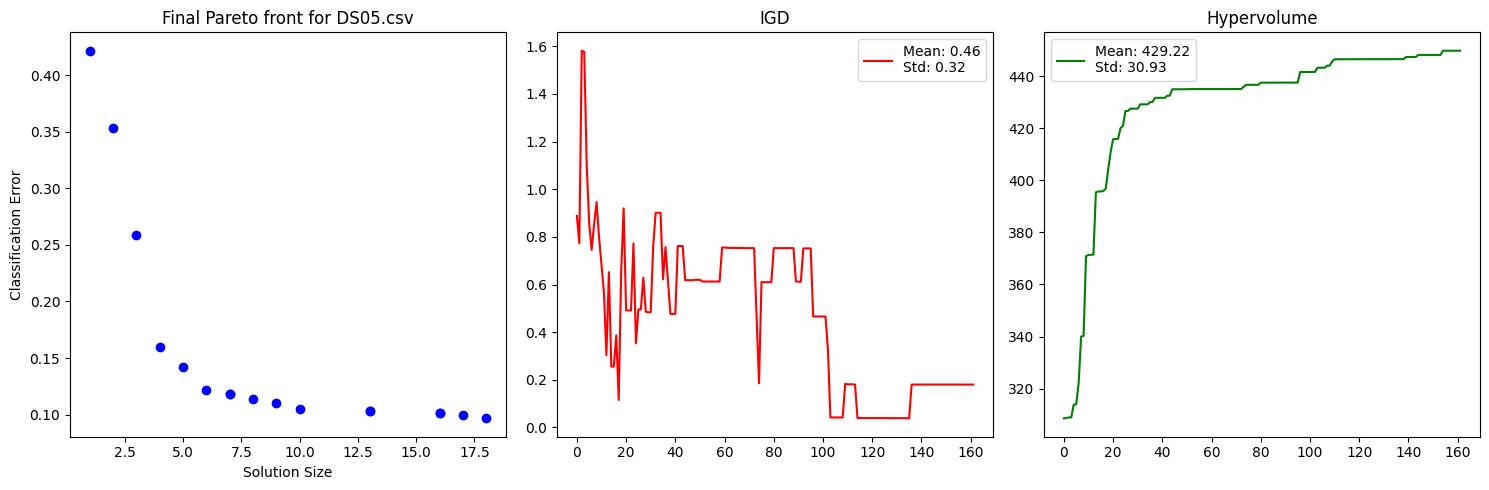

number of features:  500
Evaluations: 2500, HV: 427.4933333333334, IGD: 0.6391919392812959
Evaluations: 5000, HV: 442.43499999999995, IGD: 0.044119571428571425


In [ ]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []

for _ in range(2):
    run_different_dataset(datasets[2])

doc = Document(document_path)
data = list(zip([datasets[2]]*5, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  500
Evaluations: 2500, HV: 428.93000000000006, IGD: 0.22067041343554322
Evaluations: 5000, HV: 439.89833333333337, IGD: 0.05054814285714286
Evaluations: 7500, HV: 442.395, IGD: 0.3303544299792951
Evaluations: 10000, HV: 444.85, IGD: 0.0453100476190476
Evaluations: 12500, HV: 444.8833333333334, IGD: 0.4701108318759462
Evaluations: 15000, HV: 446.52, IGD: 0.4696333593411081
Evaluations: 17500, HV: 448.14833333333337, IGD: 0.1839187715171374
Evaluations: 17800, HV: 448.14833333333337, IGD: 0.18391877151713734
No improvement in the last 25 generations. Stopping the algorithm.


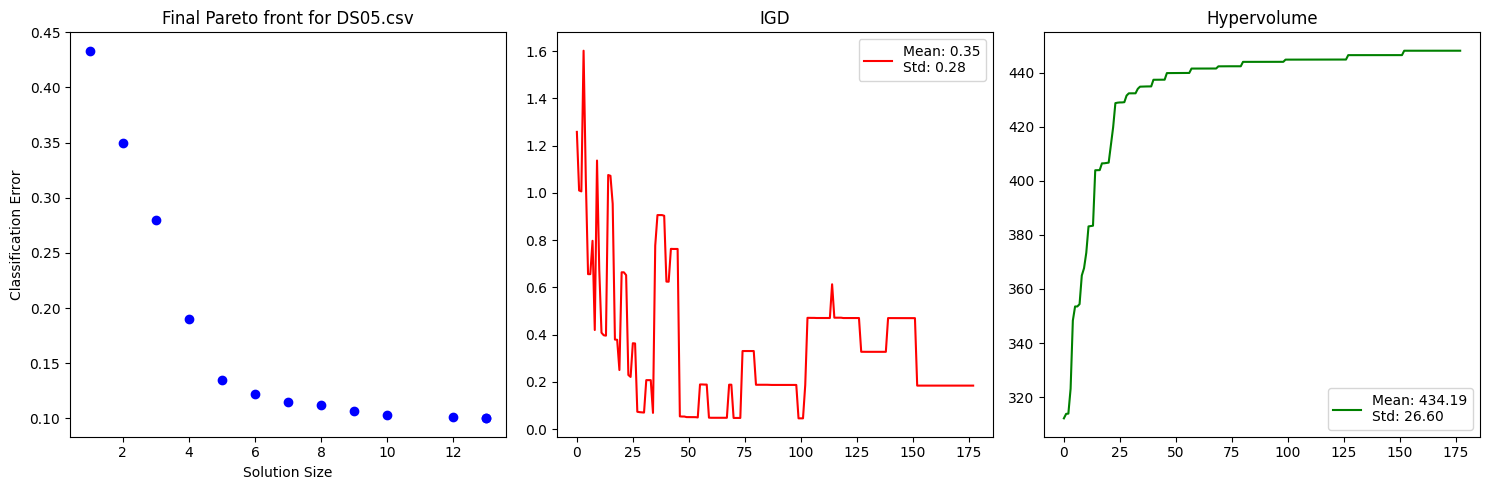

number of features:  500
Evaluations: 2500, HV: 418.3916666666666, IGD: 0.7906415983281967
Evaluations: 5000, HV: 434.9750000000001, IGD: 0.7651212096840032
Evaluations: 7500, HV: 441.5716666666667, IGD: 0.47119861918824657
Evaluations: 10000, HV: 442.4266666666666, IGD: 0.1868598926988175
Evaluations: 12500, HV: 442.45, IGD: 0.7560640577414416
Evaluations: 12800, HV: 442.45, IGD: 0.7560640577414416
No improvement in the last 25 generations. Stopping the algorithm.


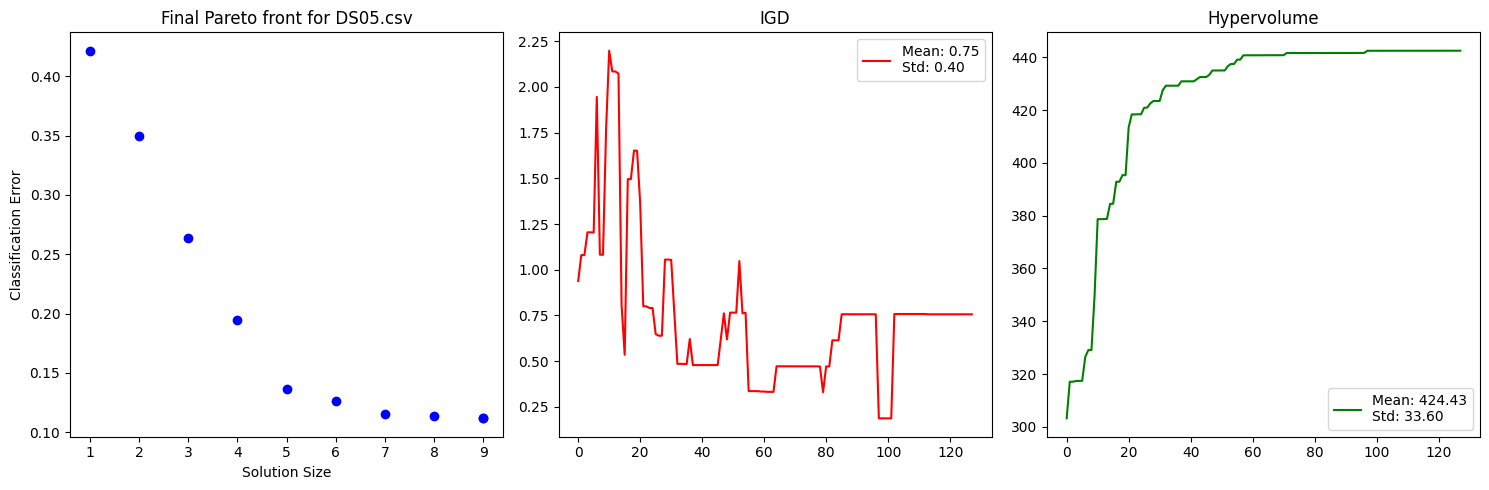

number of features:  500
Evaluations: 2500, HV: 425.0616666666667, IGD: 1.4806290767189232
Evaluations: 5000, HV: 442.43, IGD: 0.7560640577414416
Evaluations: 7500, HV: 444.10833333333335, IGD: 0.46522930631495013
Evaluations: 10000, HV: 447.3683333333334, IGD: 0.32236712181713695
Evaluations: 10300, HV: 448.9783333333334, IGD: 0.32236712181713695
No improvement in the last 25 generations. Stopping the algorithm.


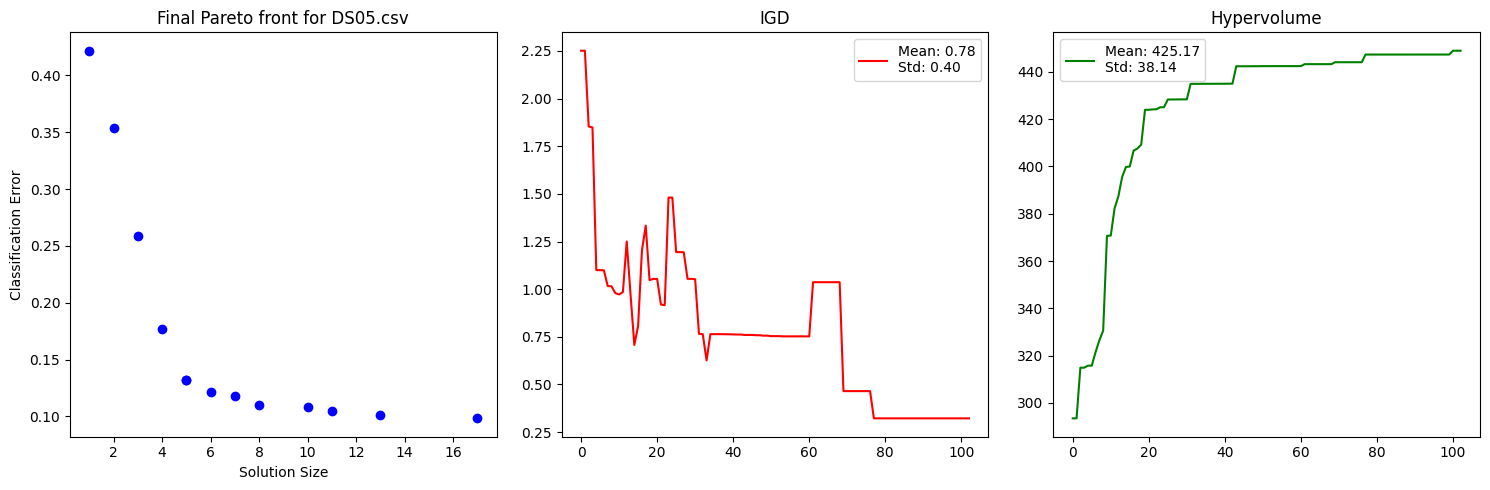

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS05.csv  |           178 |   434.188 |  26.5986 |   0.352397 |  0.276438 |         37 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS05.csv  |           128 |   424.434 |  33.6046 |   0.747464 |  0.397666 |         28 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS05.csv  |           103 |   425.171 |  38.136  |   0.7811   |  0.402544 |         21 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [20]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []


for _ in range(3):
    run_different_dataset(datasets[2])

doc = Document(document_path)
data = list(zip([datasets[2]]*3, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  500
Evaluations: 2500, HV: 430.81833333333327, IGD: 1.3405133041369133
Evaluations: 5000, HV: 441.57000000000005, IGD: 0.47311174328381733
Evaluations: 7500, HV: 445.6683333333333, IGD: 0.1872560883475027
Evaluations: 10000, HV: 446.5400000000001, IGD: 0.6137921066124249
Evaluations: 12500, HV: 447.36, IGD: 0.7561715168660949
Evaluations: 15000, HV: 449.0183333333333, IGD: 1.0406952096792126
Evaluations: 17500, HV: 449.8566666666667, IGD: 0.7518856633639757
Evaluations: 20000, HV: 450.6766666666666, IGD: 0.7527095766370789
Evaluations: 22500, HV: 451.49333333333334, IGD: 0.18128187278561433
Evaluations: 25000, HV: 451.4933333333334, IGD: 0.6098526110542413
Evaluations: 27500, HV: 452.30333333333334, IGD: 0.03917471428571427
Evaluations: 30000, HV: 452.3066666666667, IGD: 0.3241390819878239


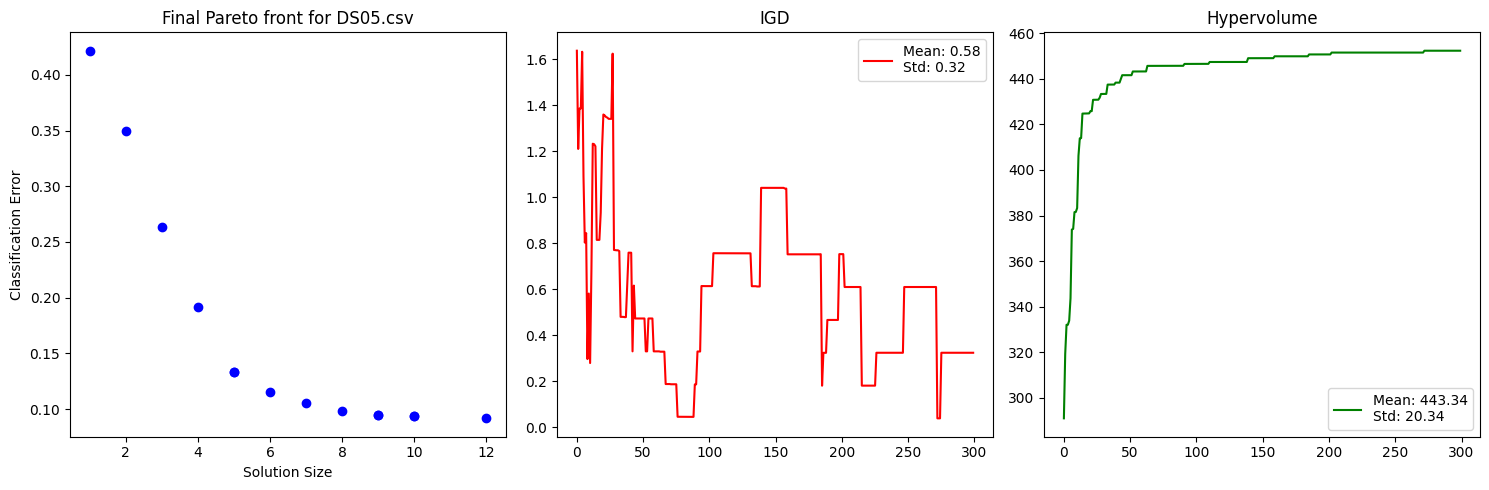

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS05.csv  |           300 |    443.34 |   20.337 |   0.582867 |   0.31953 |         62 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [22]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []
run_different_dataset(datasets[2])
doc = Document(document_path)
data = list(zip([datasets[2]]*3, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

In [23]:
doc.save(document_path)


number of features:  561

Evaluations: 100000, HV: 542.0255555555556, IGD: 2.4288419141085584

Evaluations: 200000, HV: 548.6122222222222, IGD: 0.18200412428615262

Evaluations: 300000, HV: 549.2444444444444, IGD: 0.17772037702437637


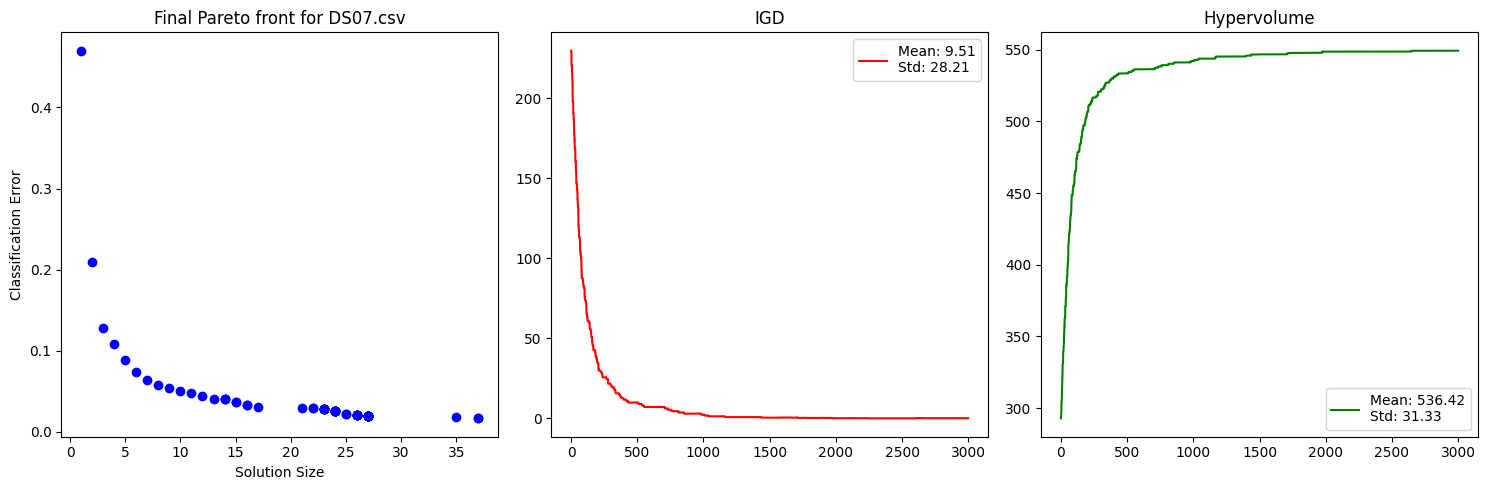

In [18]:
# random initialize
run_different_dataset(datasets[3])

In [ ]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []

number of features:  561
Evaluations: 2500, HV: 519.4311111111111, IGD: 0.6003264953791824
Evaluations: 5000, HV: 526.8477777777777, IGD: 0.5127822101086469
Evaluations: 7500, HV: 530.5322222222222, IGD: 0.09765431169949744
Evaluations: 10000, HV: 534.1888888888889, IGD: 0.09627895792433223
Evaluations: 12300, HV: 534.8233333333333, IGD: 0.1768330793337041
No improvement in the last 30 generations. Stopping the algorithm.


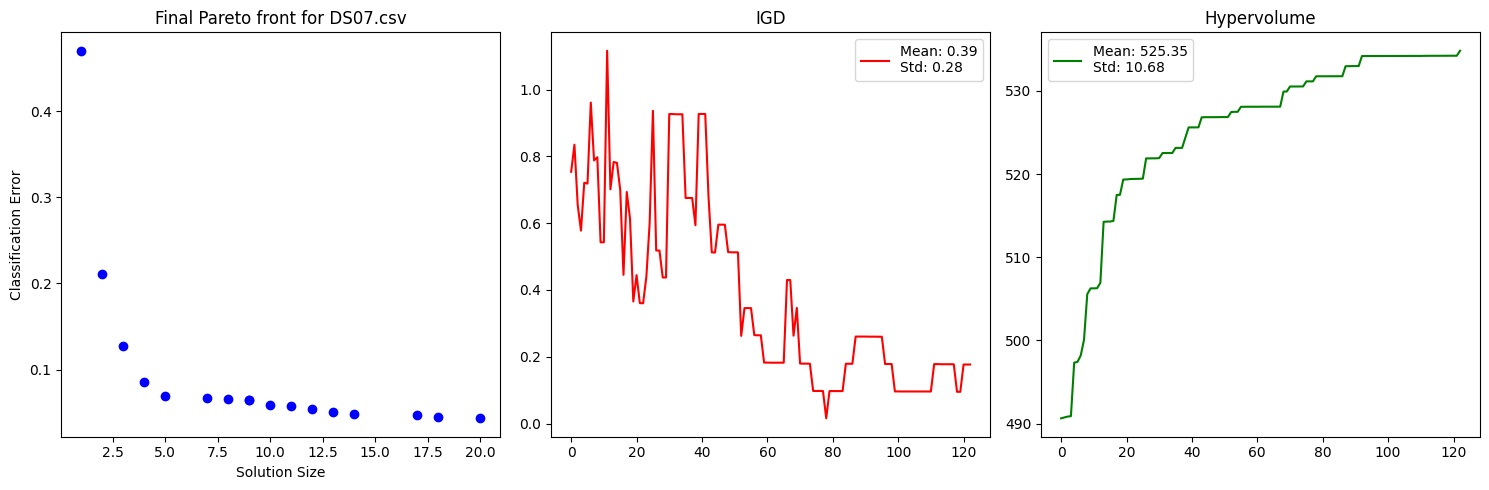

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS07.csv  |           123 |   525.347 |  10.6764 |   0.387856 |  0.275901 |         36 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [25]:
# wise initialization run 1
run_different_dataset(datasets[3])
doc = Document(document_path)
data = list(zip([datasets[3]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 520.0666666666667, IGD: 0.6014873000297971
Evaluations: 5000, HV: 526.2822222222222, IGD: 0.9271185782770609
Evaluations: 7500, HV: 528.7533333333333, IGD: 1.007548478536801
Evaluations: 10000, HV: 529.9855555555556, IGD: 0.757834108790984
Evaluations: 12500, HV: 530.6111111111111, IGD: 0.6740194246369821
Evaluations: 15000, HV: 532.4433333333334, IGD: 0.175392224780993
Evaluations: 17500, HV: 533.07, IGD: 0.33951519390891854
Evaluations: 20000, HV: 534.2855555555554, IGD: 0.42275165429895883
Evaluations: 20700, HV: 534.2855555555554, IGD: 0.42275165429895883
No improvement in the last 30 generations. Stopping the algorithm.


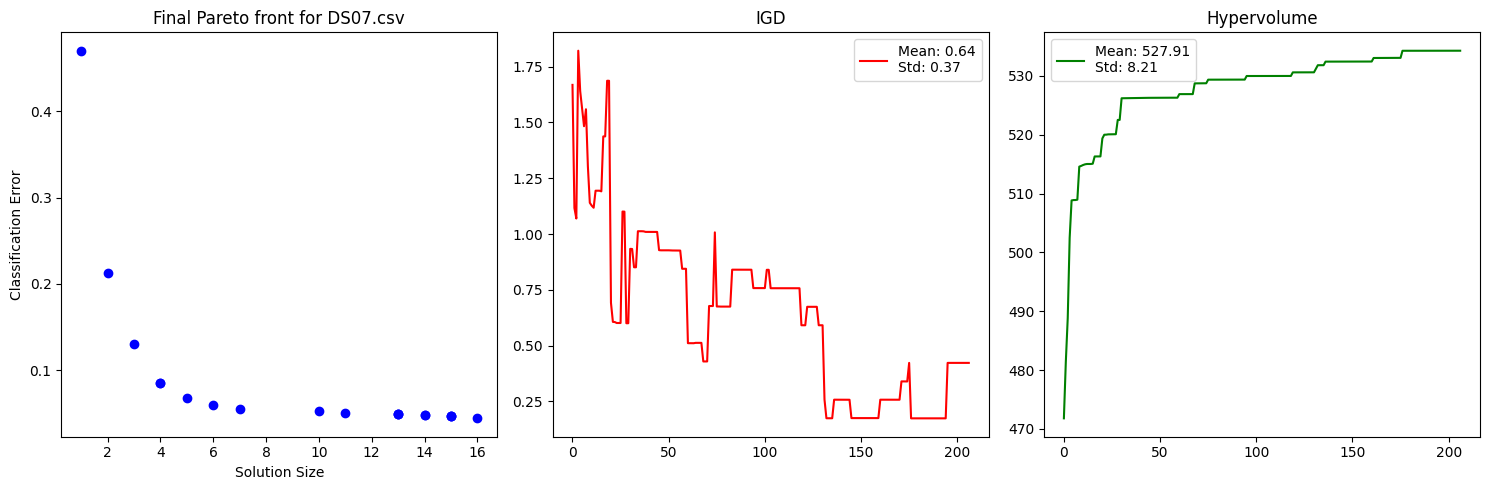

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS07.csv  |           207 |   527.906 |  8.21121 |    0.63647 |  0.374126 |         64 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [27]:
#wise intialization run 2
run_different_dataset(datasets[3])
doc = Document(document_path)
data = list(zip([datasets[3]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 518.2422222222223, IGD: 0.43377426867220503
Evaluations: 5000, HV: 523.8033333333334, IGD: 0.26457155931587567
Evaluations: 7500, HV: 527.5066666666667, IGD: 0.7574636052376004
Evaluations: 9700, HV: 527.541111111111, IGD: 1.0093147824619348
No improvement in the last 30 generations. Stopping the algorithm.


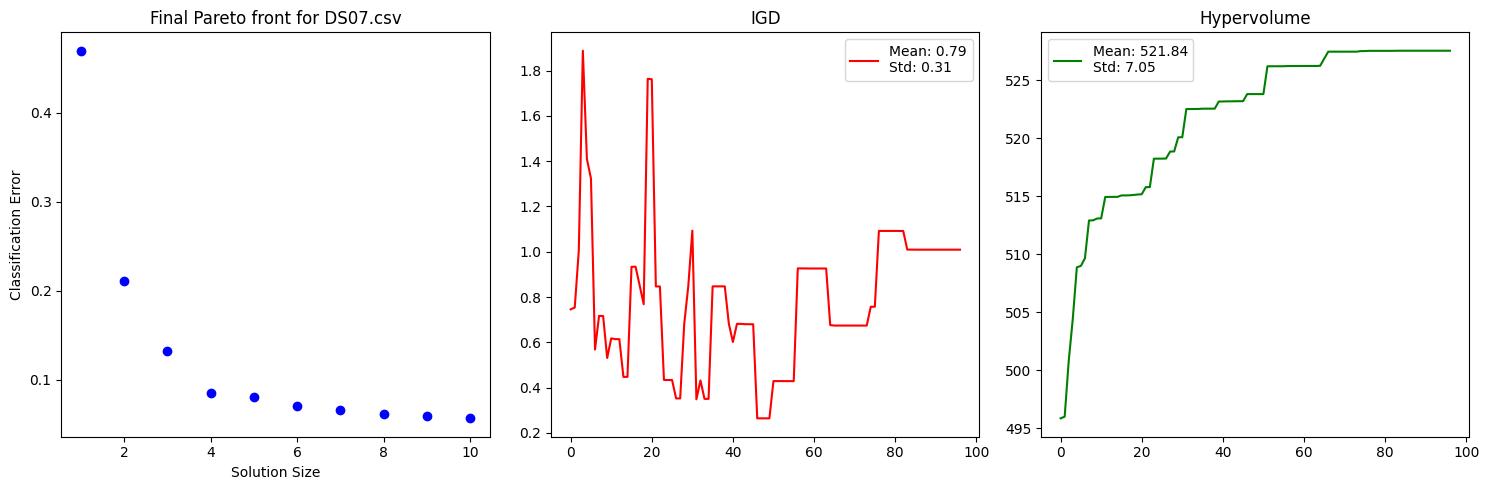

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS07.csv  |           207 |   527.906 |  8.21121 |    0.63647 |  0.374126 |         64 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [29]:
# wise initialization run 3
run_different_dataset(datasets[3])
doc = Document(document_path)
data = list(zip([datasets[3]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 521.828888888889, IGD: 0.11016953839484574
Evaluations: 5000, HV: 527.478888888889, IGD: 0.9294634170984861
Evaluations: 7500, HV: 531.1177777777779, IGD: 0.2614841437604146
Evaluations: 10000, HV: 531.168888888889, IGD: 0.5932752234493427
Evaluations: 12500, HV: 533.6155555555556, IGD: 0.34316292168627266
Evaluations: 15000, HV: 533.6255555555556, IGD: 0.26087365477407204
Evaluations: 15300, HV: 533.6266666666667, IGD: 0.26078106218147945
No improvement in the last 30 generations. Stopping the algorithm.


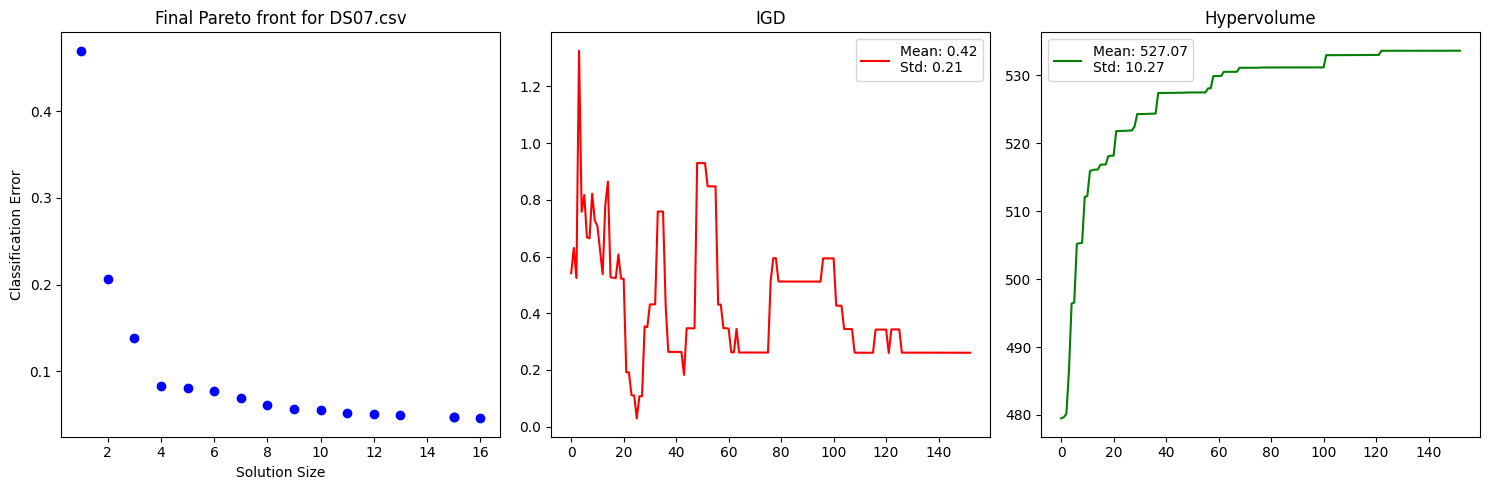

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS07.csv  |           207 |   527.906 |  8.21121 |   0.63647  |  0.374126 |         64 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS07.csv  |            97 |   521.835 |  7.04768 |   0.787352 |  0.312989 |         30 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS07.csv  |           116 |   525.097 |  7.9582  |   0.58512  |  0.223455 |         37 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [33]:
# wise initialization run 4
run_different_dataset(datasets[3])
doc = Document(document_path)
data = list(zip([datasets[3]]*3, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)

print(table)
doc.save(document_path)

In [20]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []

number of features:  561
Evaluations: 2500, HV: 513.8808333333334, IGD: 3.5499004154713143
Evaluations: 5000, HV: 518.5516666666667, IGD: 2.4795352075414665
Evaluations: 6900, HV: 519.9608333333334, IGD: 2.082159706895184
No improvement in the last 20 generations. Stopping the algorithm.


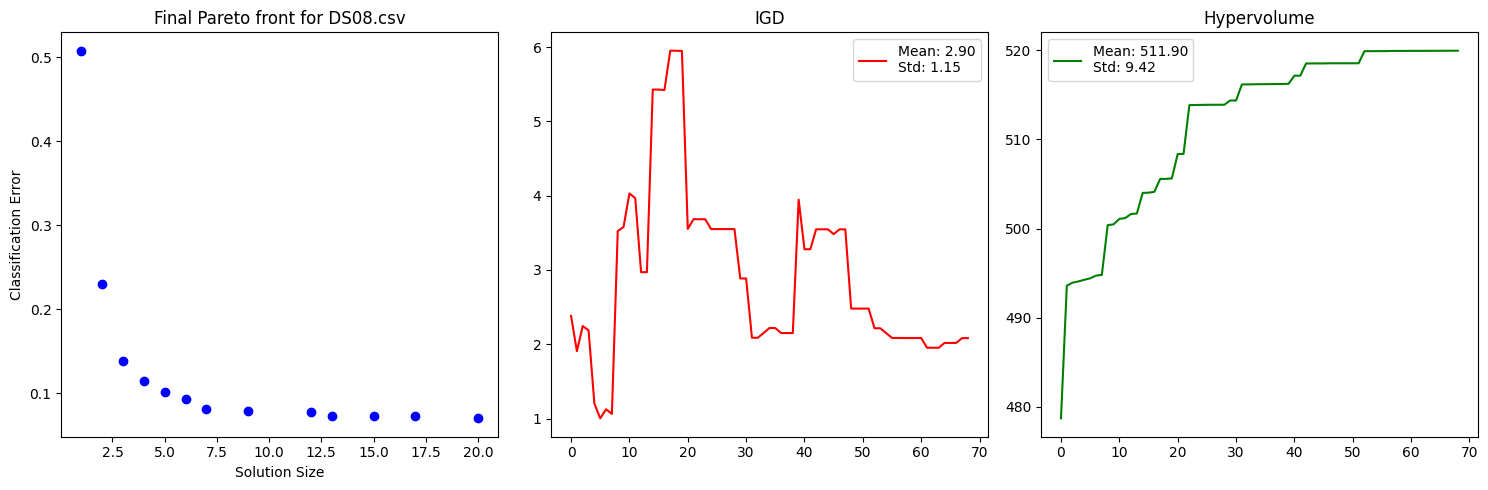

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS10.csv  |            69 |   511.902 |  9.41523 |     2.9042 |    1.1468 |         22 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [21]:
# wise initialization run 1
run_different_dataset(datasets[4])
doc = Document(document_path)
data = list(zip([datasets[5]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561


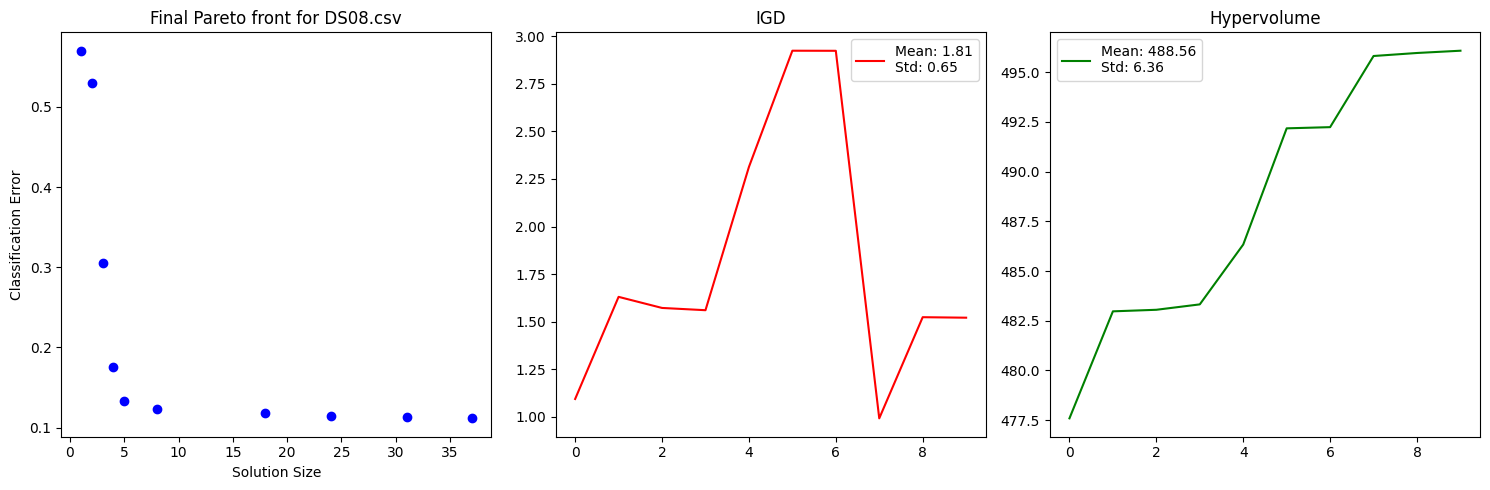

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |            69 |   511.902 |  9.41523 |    2.9042  |  1.1468   |         22 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |            10 |   488.556 |  6.3635  |    1.80508 |  0.651261 |          3 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [26]:
# wise initialization run 2
run_different_dataset(datasets[4])
doc = Document(document_path)
data = list(zip([datasets[4]]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 510.6033333333334, IGD: 2.954740522925503
Evaluations: 5000, HV: 515.815, IGD: 3.8153195275987355
Evaluations: 7500, HV: 519.0799999999999, IGD: 5.343190967819667
Evaluations: 10000, HV: 521.8208333333333, IGD: 2.743970848330522


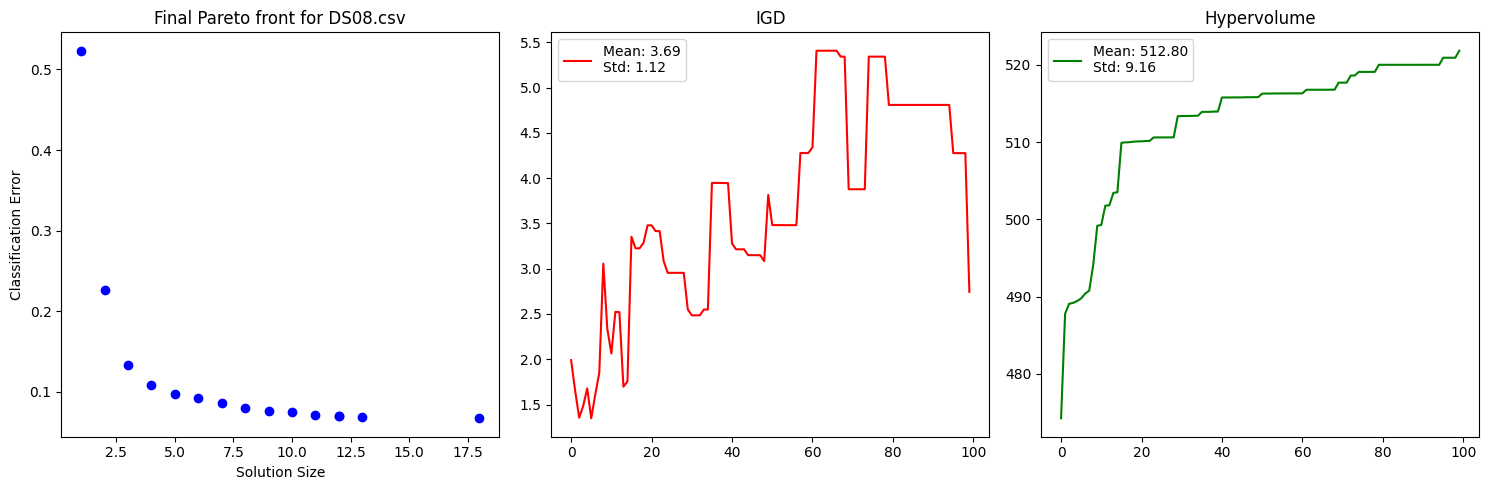

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |            69 |   511.902 |  9.41523 |    2.9042  |  1.1468   |         22 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |            10 |   488.556 |  6.3635  |    1.80508 |  0.651261 |          3 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           100 |   512.801 |  9.15733 |    3.68532 |  1.12288  |         32 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [29]:
# wise initialization run 3
run_different_dataset(datasets[4])
doc = Document(document_path)
data = list(zip([datasets[4]]*3, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 514.5925, IGD: 2.4317633980800135
Evaluations: 5000, HV: 518.8525000000001, IGD: 1.3572596163501942
Evaluations: 7500, HV: 519.4483333333334, IGD: 2.550506310392839
Evaluations: 9100, HV: 519.4683333333334, IGD: 2.550803149515675
No improvement in the last 25 generations. Stopping the algorithm.


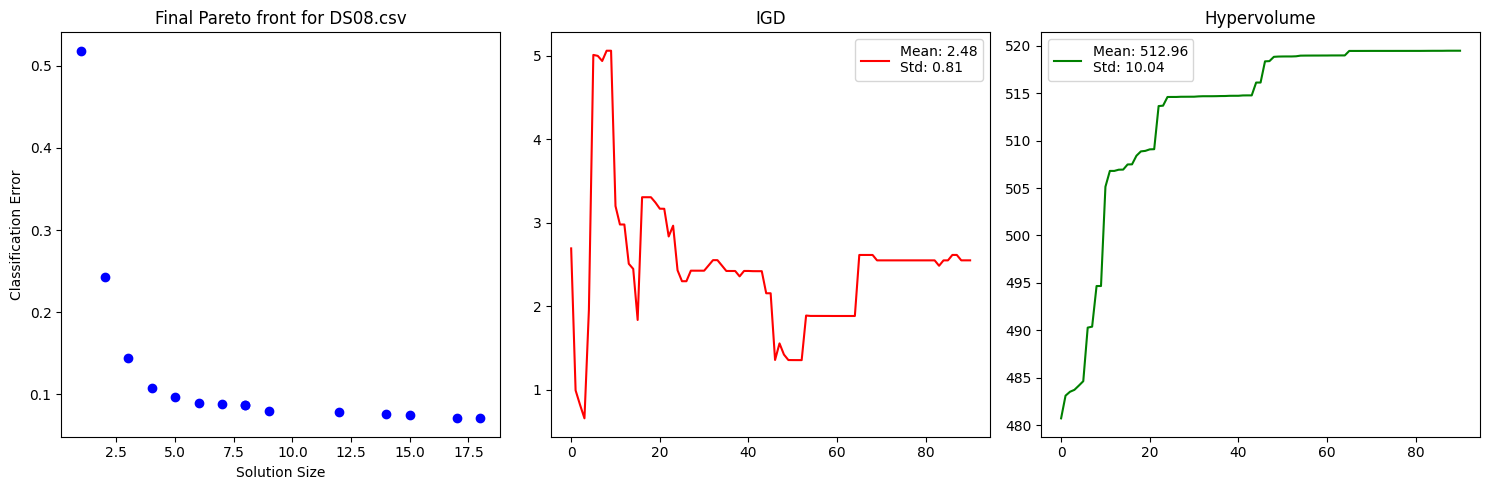

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |            69 |   511.902 |  9.41523 |    2.9042  |  1.1468   |         22 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |            10 |   488.556 |  6.3635  |    1.80508 |  0.651261 |          3 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           100 |   512.801 |  9.15733 |    3.68532 |  1.12288  |         32 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |            91 |   512.957 | 10.0353  |    2.47645 |  0.806087 |         29 |
+-----------+---------------+-----------+----------+------------+-----------+------------+

In [31]:
# wise initialization run 4
run_different_dataset(datasets[4])
doc = Document(document_path)
data = list(zip([datasets[4]]*4, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 509.31166666666667, IGD: 4.349633835499474
Evaluations: 5000, HV: 516.325, IGD: 5.876751983498414
Evaluations: 7500, HV: 516.3666666666667, IGD: 5.875559983498415
Evaluations: 7900, HV: 516.3666666666667, IGD: 5.875559983498415
No improvement in the last 30 generations. Stopping the algorithm.


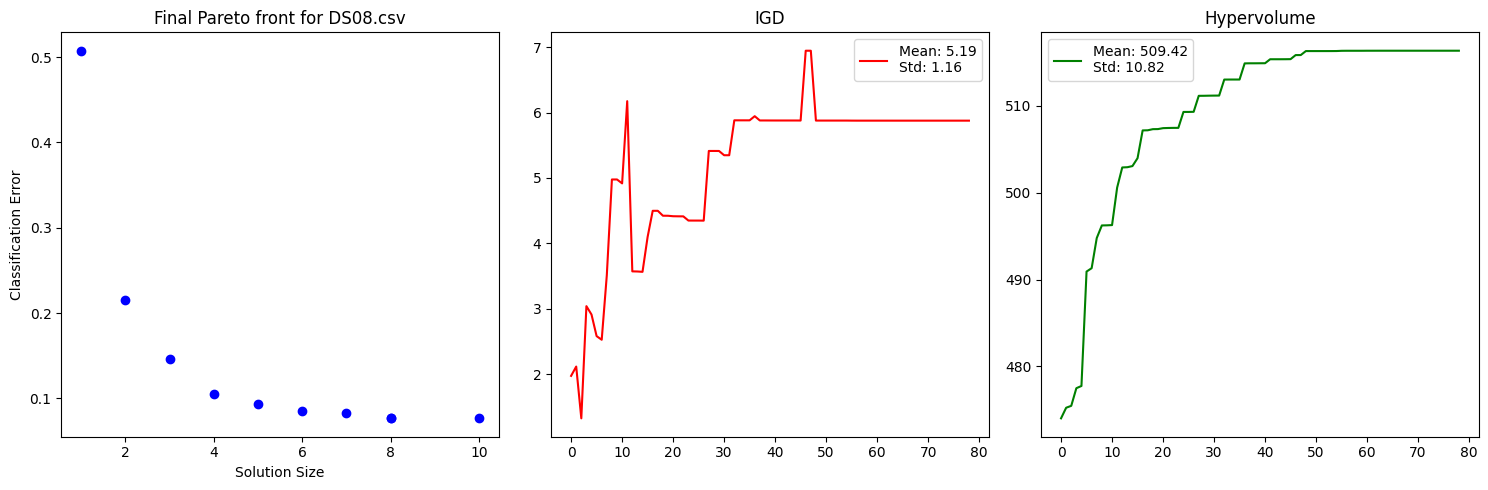

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |            69 |   511.902 |  9.41523 |    2.9042  |  1.1468   |         22 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |            10 |   488.556 |  6.3635  |    1.80508 |  0.651261 |          3 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           100 |   512.801 |  9.15733 |    3.68532 |  1.12288  |         32 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |            91 |   512.957 | 10.0353  |    2.47645 |  0.806087 |         29 |
+-----------+---------------+-----------+----------+------------+-----------+------------+

In [34]:
# wise initialization run 5
run_different_dataset(datasets[4])
doc = Document(document_path)
data = list(zip([datasets[4]]*5, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 509.6383333333333, IGD: 3.3536951006290496
Evaluations: 5000, HV: 520.7666666666667, IGD: 2.947624398695578
Evaluations: 7500, HV: 523.15, IGD: 2.880534364474754
Evaluations: 10000, HV: 524.5708333333333, IGD: 2.279209124046206
Evaluations: 12500, HV: 525.9325000000001, IGD: 1.9481560989773061
Evaluations: 12600, HV: 525.9325000000001, IGD: 1.9481560989773061
No improvement in the last 50 generations. Stopping the algorithm.


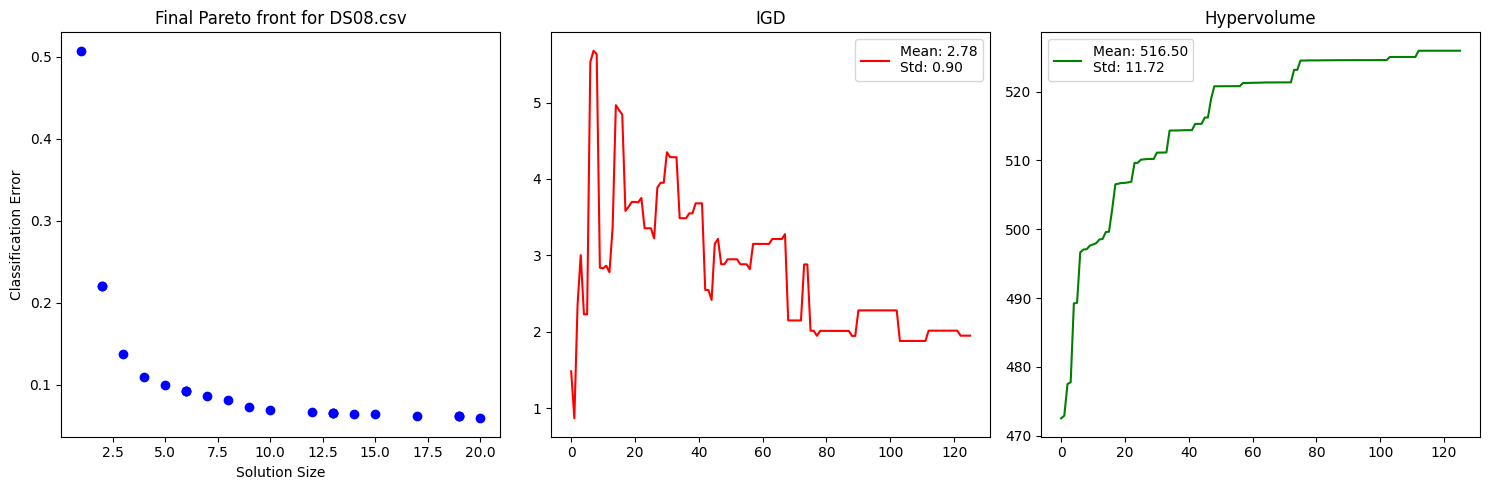

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |           126 |   516.503 |  11.7208 |    2.77915 |  0.897477 |         46 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [26]:
# wise initialization run 5
run_different_dataset(datasets[4])

doc = Document(document_path)
data = list(zip([datasets[4]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 508.785, IGD: 4.2899870695385065
Evaluations: 5000, HV: 517.2216666666668, IGD: 2.8805988552734036
Evaluations: 7500, HV: 519.0933333333334, IGD: 3.8113281769254916
Evaluations: 10000, HV: 521.4041666666667, IGD: 4.276248146146118
Evaluations: 12500, HV: 521.4116666666667, IGD: 4.808718862837621
Evaluations: 15000, HV: 522.3333333333334, IGD: 4.275854487971686
Evaluations: 17500, HV: 522.335, IGD: 4.275798932416131
Evaluations: 17600, HV: 522.335, IGD: 4.275798932416131
No improvement in the last 50 generations. Stopping the algorithm.


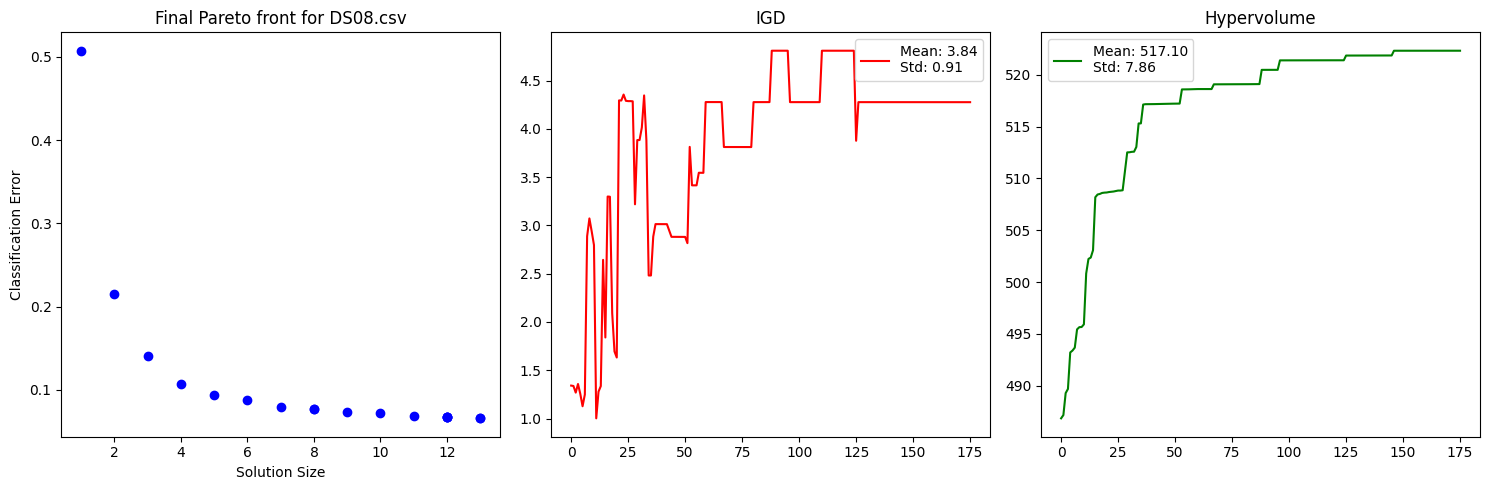

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |           176 |     517.1 |  7.86263 |    3.84496 |  0.909744 |         75 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [23]:
# wise initialization run 6

run_different_dataset(datasets[4])
doc = Document(document_path)
data = list(zip([datasets[4]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 511.04, IGD: 2.956865725189382
Evaluations: 5000, HV: 516.6958333333333, IGD: 3.418599211121733
Evaluations: 7500, HV: 519.0341666666667, IGD: 2.283030902348629
Evaluations: 10000, HV: 521.7866666666667, IGD: 3.480039269923443
Evaluations: 12500, HV: 524.0708333333333, IGD: 2.548130790724656
Evaluations: 15000, HV: 525.0008333333333, IGD: 2.7480720752426233
Evaluations: 17500, HV: 525.0058333333333, IGD: 2.747905408575956
Evaluations: 17600, HV: 525.0058333333333, IGD: 2.747905408575956
No improvement in the last 70 generations. Stopping the algorithm.


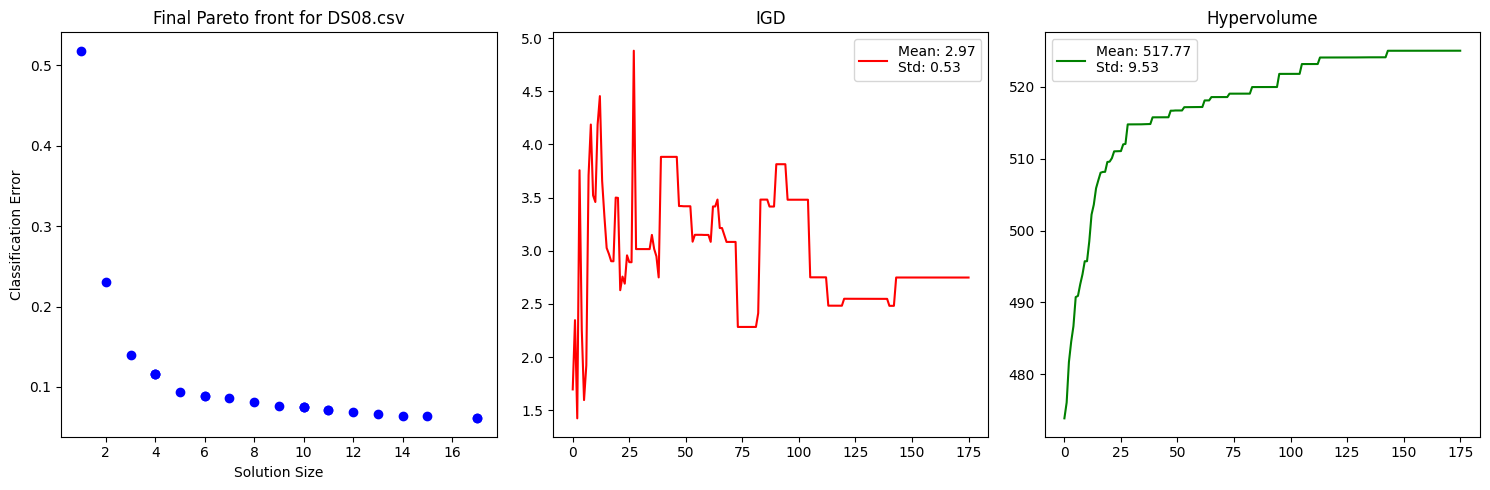

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |           176 |   517.1   |  7.86263 |    3.84496 |  0.909744 |         75 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           176 |   517.771 |  9.52984 |    2.97462 |  0.529173 |         75 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [27]:
# wise initialization run 6

run_different_dataset(datasets[4])
doc = Document(document_path)
data = list(zip([datasets[4]]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 509.6908333333333, IGD: 3.223633855134324
Evaluations: 5000, HV: 514.8866666666667, IGD: 3.61291611405147
Evaluations: 7500, HV: 519.4925000000001, IGD: 3.0797745246440145
Evaluations: 10000, HV: 519.5075, IGD: 2.815903712367109
Evaluations: 12500, HV: 521.3308333333333, IGD: 2.548646066846786
Evaluations: 15000, HV: 521.8066666666666, IGD: 3.4797301711791224
Evaluations: 17500, HV: 522.7258333333333, IGD: 3.4792227510178773
Evaluations: 20000, HV: 523.6525, IGD: 3.4125748841919763
Evaluations: 20300, HV: 523.6533333333333, IGD: 3.4125748841919763
No improvement in the last 70 generations. Stopping the algorithm.


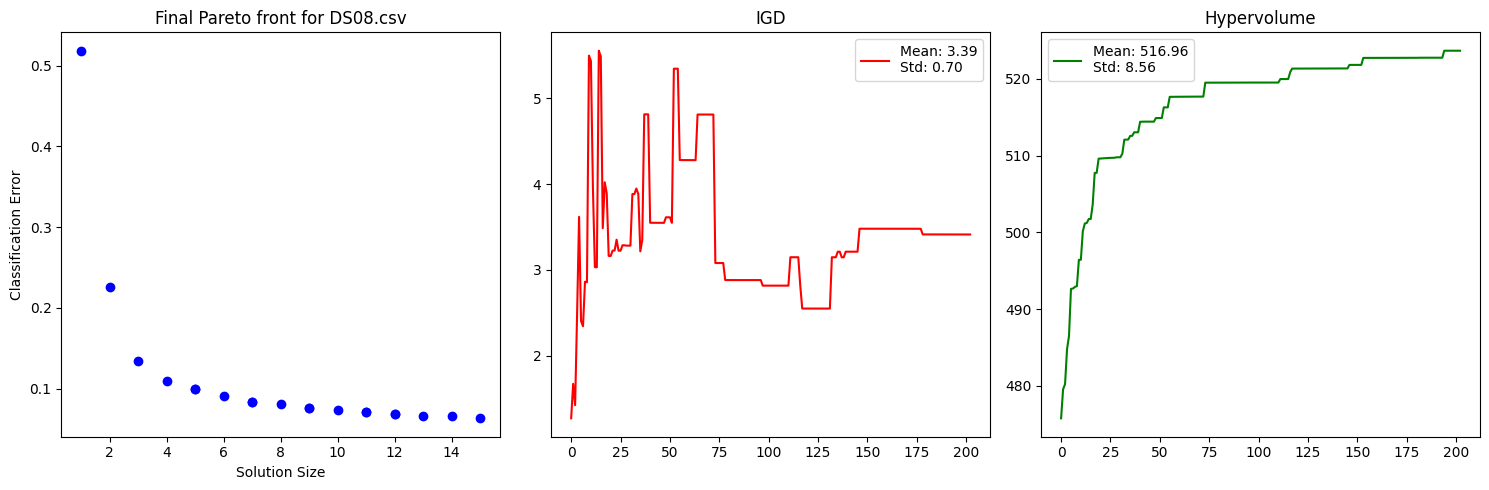

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |           176 |   517.1   |  7.86263 |    3.84496 |  0.909744 |         75 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           176 |   517.771 |  9.52984 |    2.97462 |  0.529173 |         75 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [30]:
# wise initialization run 7
run_different_dataset(datasets[4])
doc = Document(document_path)
data = list(zip([datasets[4]]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

In [33]:
doc = Document(document_path)
data = list(zip([datasets[4]]*3, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |           176 |   517.1   |  7.86263 |    3.84496 |  0.909744 |         75 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           176 |   517.771 |  9.52984 |    2.97462 |  0.529173 |         75 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           203 |   516.959 |  8.56181 |    3.39018 |  0.703712 |         85 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


number of features:  561
Evaluations: 2500, HV: 510.3991666666667, IGD: 1.846061478832322
Evaluations: 5000, HV: 518.9933333333332, IGD: 1.1691291281647915
Evaluations: 7500, HV: 523.39, IGD: 0.9139144031457762
Evaluations: 10000, HV: 526.5600000000001, IGD: 0.635400571416723
Evaluations: 12500, HV: 526.7391666666667, IGD: 0.9007359241839996
Evaluations: 15000, HV: 527.2675, IGD: 0.7650564459499737
No improvement in the last 70 generations. Stopping the algorithm.


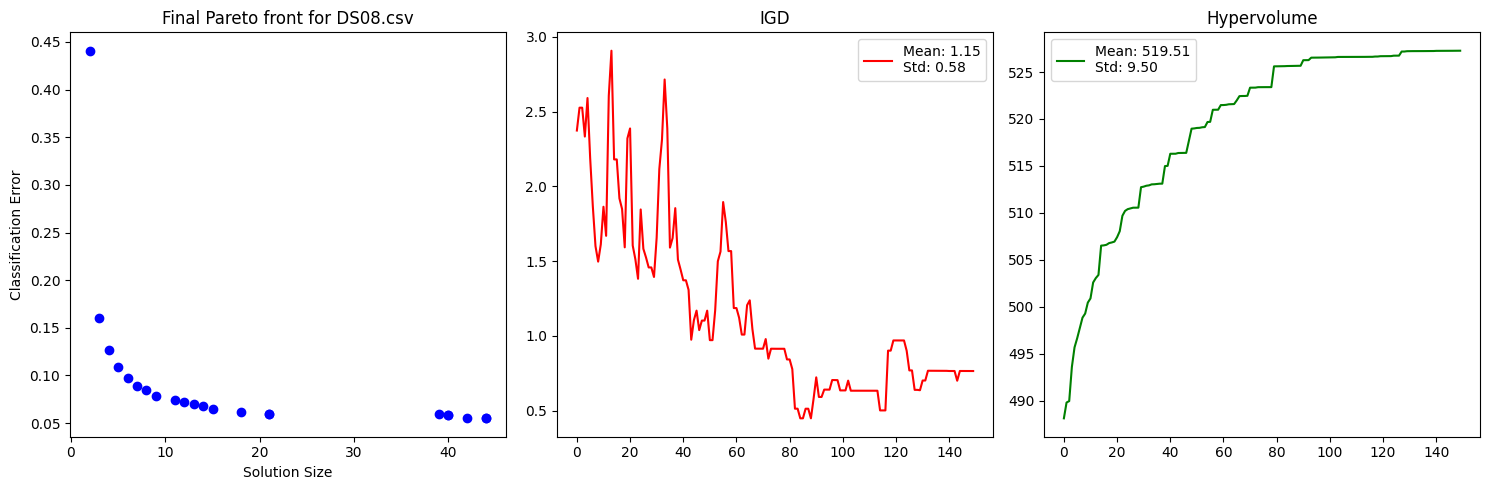

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS08.csv  |           176 |   517.1   |  7.86263 |    3.84496 |  0.909744 |         75 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           176 |   517.771 |  9.52984 |    2.97462 |  0.529173 |         75 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           203 |   516.959 |  8.56181 |    3.39018 |  0.703712 |         85 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS08.csv  |           150 |   519.515 |  9.49819 |    1.1457  |  0.580561 |         64 |
+-----------+---------------+-----------+----------+------------+-----------+------------+

In [34]:
# random wise initialization run 8
run_different_dataset(datasets[4])
doc = Document(document_path)
data = list(zip([datasets[4]]*4, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  649

Evaluations: 25000, HV: 591.9554824285364, IGD: 26.928896199185708

Evaluations: 50000, HV: 609.0753687819556, IGD: 14.073136268640786

Evaluations: 75000, HV: 615.8413743084402, IGD: 8.64583942329659

Evaluations: 100000, HV: 621.4474144803486, IGD: 5.086199016790782


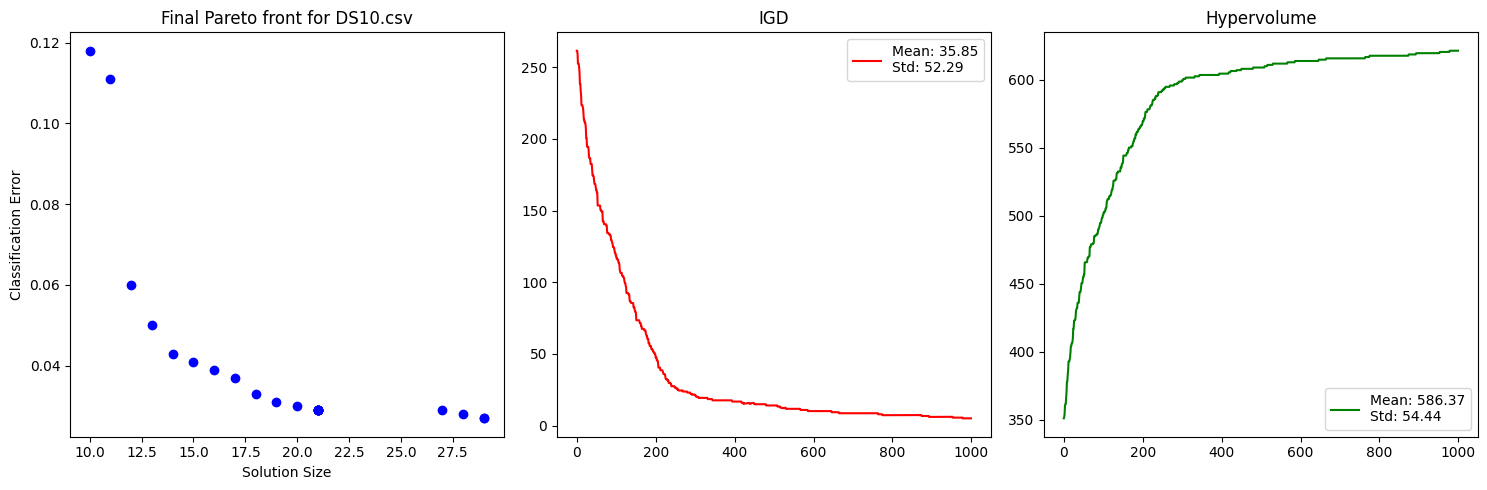

In [24]:
#random initialization
run_different_dataset(datasets[5])

In [20]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []

number of features:  649
Evaluations: 2500, HV: 611.632737527947, IGD: 1.2758337721364317
Evaluations: 5000, HV: 617.7362062661464, IGD: 3.3122507439739466
Evaluations: 7500, HV: 619.201255147363, IGD: 4.166399433306316
Evaluations: 10000, HV: 620.7387537237837, IGD: 3.594356552557652
Evaluations: 12500, HV: 621.4102815390241, IGD: 3.807881647974484
Evaluations: 15000, HV: 622.0461629293965, IGD: 3.7373498340344704
Evaluations: 17500, HV: 622.7014919110727, IGD: 3.451207384076627
Evaluations: 20000, HV: 622.7065268861675, IGD: 3.949930515780335
Evaluations: 22500, HV: 622.7125418832005, IGD: 4.163996491310138
Evaluations: 25000, HV: 622.7135668602734, IGD: 4.163923278662076
Evaluations: 27300, HV: 622.7195668722615, IGD: 4.163851778590575
No improvement in the last 50 generations. Stopping the algorithm.


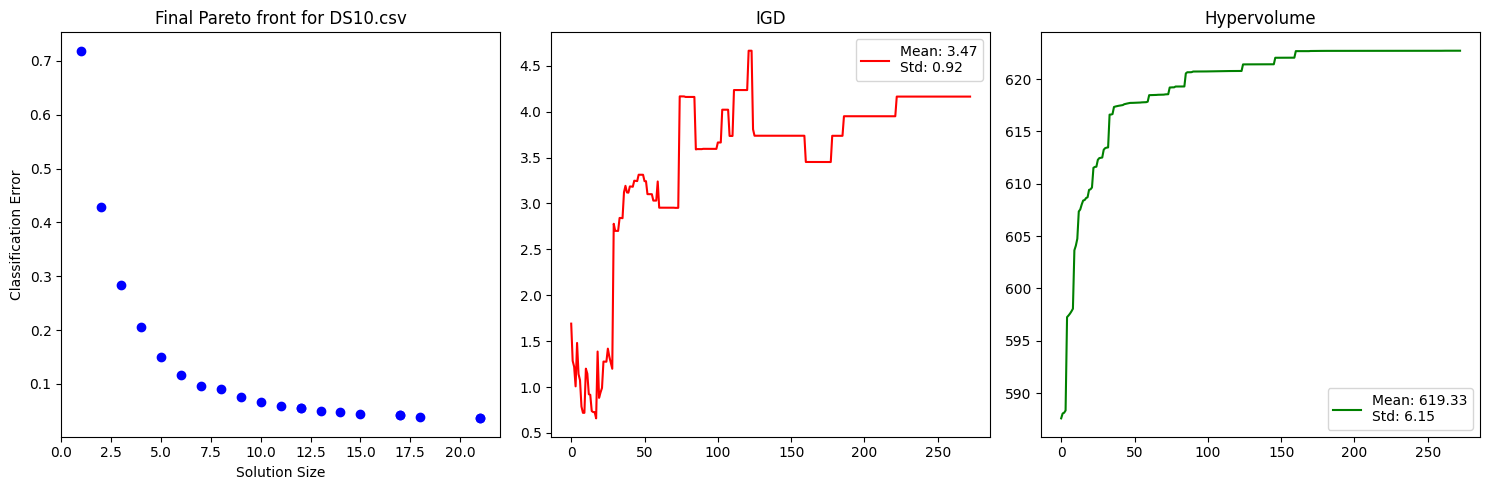

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS10.csv  |           273 |   619.325 |  6.14583 |    3.47249 |  0.918371 |         99 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [36]:
# wise initialization run 1
run_different_dataset(datasets[5])
doc = Document(document_path)
data = list(zip([datasets[5]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  649
Evaluations: 2500, HV: 613.5912259564955, IGD: 1.7630793613164253
Evaluations: 5000, HV: 616.4610328891766, IGD: 2.38827292430517
Evaluations: 7500, HV: 619.9600318881755, IGD: 2.9515112701304296
Evaluations: 10000, HV: 622.0025684367001, IGD: 4.44827925921622
Evaluations: 12500, HV: 622.0205564846283, IGD: 4.592339299566492
Evaluations: 14200, HV: 622.0505295714877, IGD: 4.591356248054757
No improvement in the last 30 generations. Stopping the algorithm.


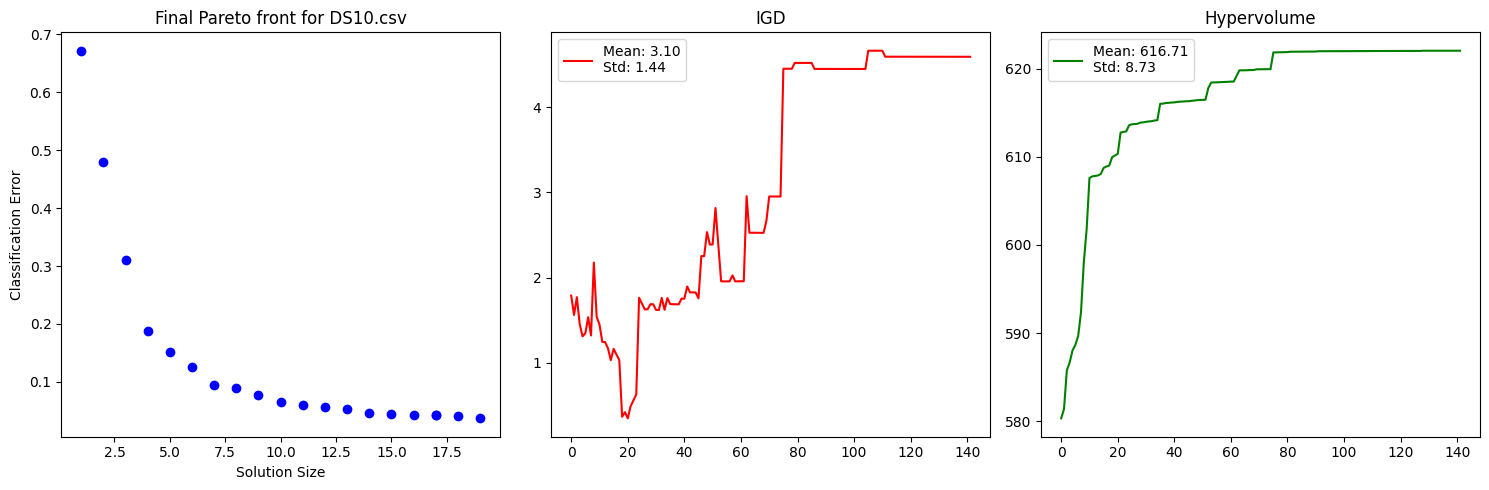

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS10.csv  |           273 |   619.325 |  6.14583 |    3.47249 |  0.918371 |         99 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [39]:
# wise initialization run 2
run_different_dataset(datasets[5])
doc = Document(document_path)
data = list(zip([datasets[5]]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  649
Evaluations: 2500, HV: 609.9646952341564, IGD: 1.0638894009926934
Evaluations: 5000, HV: 618.4456882031733, IGD: 3.2471428179659982
Evaluations: 7500, HV: 619.8979878081675, IGD: 4.094283082193935
Evaluations: 10000, HV: 620.624148100196, IGD: 4.021317477627959
Evaluations: 12500, HV: 621.2928707150264, IGD: 3.6637120691428278
Evaluations: 15000, HV: 621.9669100237962, IGD: 3.6603482826401406
Evaluations: 17500, HV: 621.9789070507633, IGD: 3.6597775665005616
Evaluations: 19400, HV: 621.9918930906955, IGD: 3.6597775665005616
No improvement in the last 50 generations. Stopping the algorithm.


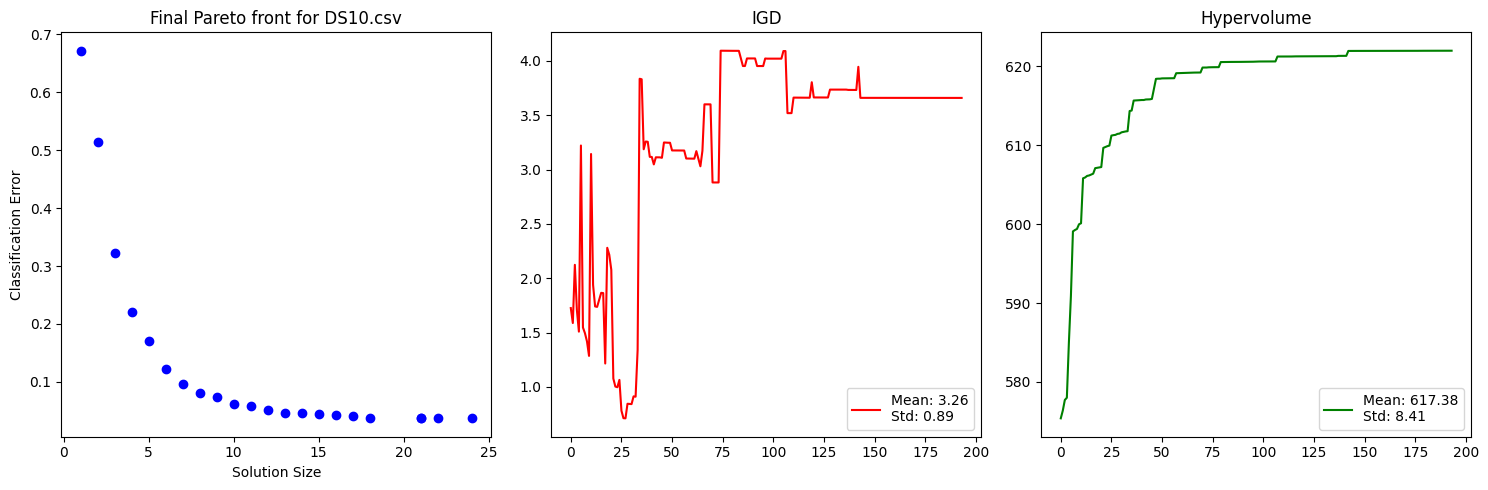

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS10.csv  |           194 |   617.376 |  8.40519 |    3.26008 |   0.88995 |         58 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [20]:
# wise initialization run 3
run_different_dataset(datasets[5])
doc = Document(document_path)
data = list(zip([datasets[5]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  649
Evaluations: 2500, HV: 613.4489879100657, IGD: 2.4550374782068554
Evaluations: 5000, HV: 619.7530614446782, IGD: 2.233537710004376
Evaluations: 7500, HV: 623.8385751020481, IGD: 2.4518296237083423
Evaluations: 10000, HV: 625.225872579166, IGD: 2.731542379557338
Evaluations: 12500, HV: 625.2828786870703, IGD: 3.586893524711835
Evaluations: 15000, HV: 626.7134589679499, IGD: 3.798377860844283
Evaluations: 17500, HV: 626.742461023898, IGD: 3.656156187111437
Evaluations: 19100, HV: 626.7474630318941, IGD: 3.656085543328218
No improvement in the last 20 generations. Stopping the algorithm.


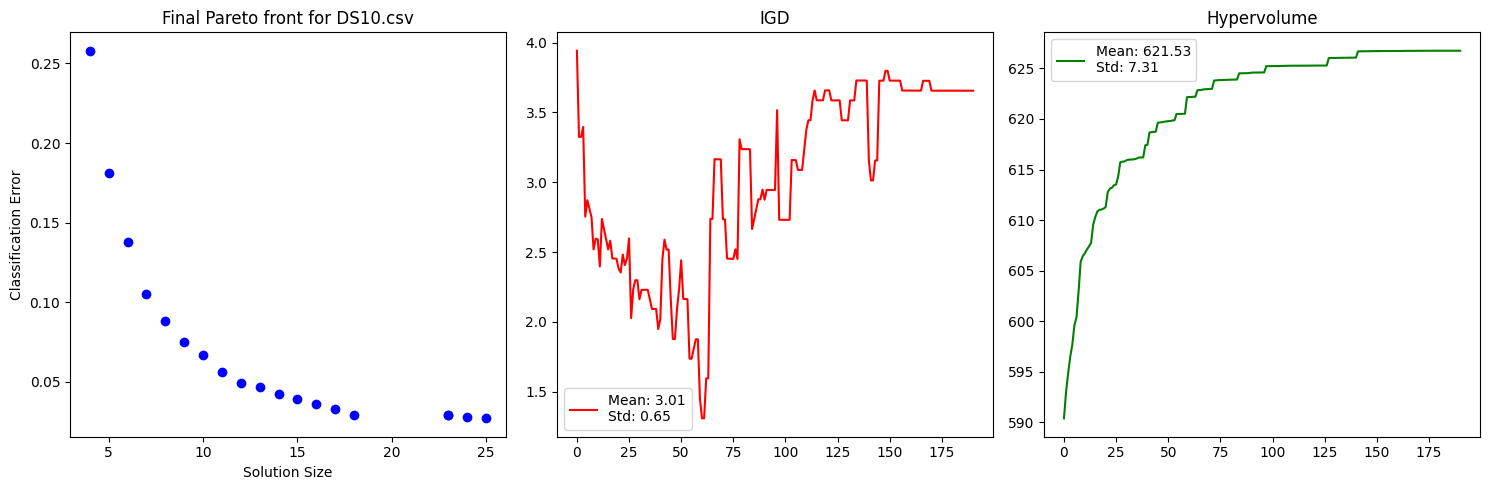

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS10.csv  |           191 |   621.531 |  7.30687 |    3.01139 |  0.646355 |         58 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [21]:
# wise initialization run 4
run_different_dataset(datasets[5])
doc = Document(document_path)
data = list(zip([datasets[5]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  649
Evaluations: 2500, HV: 617.626992261723, IGD: 0.886596538964378
Evaluations: 5000, HV: 623.8207279135422, IGD: 0.9631934230860721
Evaluations: 7500, HV: 624.8242643841446, IGD: 2.172480950562399
Evaluations: 10000, HV: 625.5474995954038, IGD: 2.9532650977988135
Evaluations: 12500, HV: 626.8142004279729, IGD: 2.88326701870268
Evaluations: 15000, HV: 627.4798481115846, IGD: 3.025768054056698
Evaluations: 17500, HV: 627.59091726457, IGD: 4.01941607641435
Evaluations: 20000, HV: 627.615954277631, IGD: 4.232480928509955
Evaluations: 22500, HV: 627.6659743575912, IGD: 4.373619826438868
Evaluations: 23400, HV: 627.6689683695672, IGD: 4.373619826438868
No improvement in the last 30 generations. Stopping the algorithm.


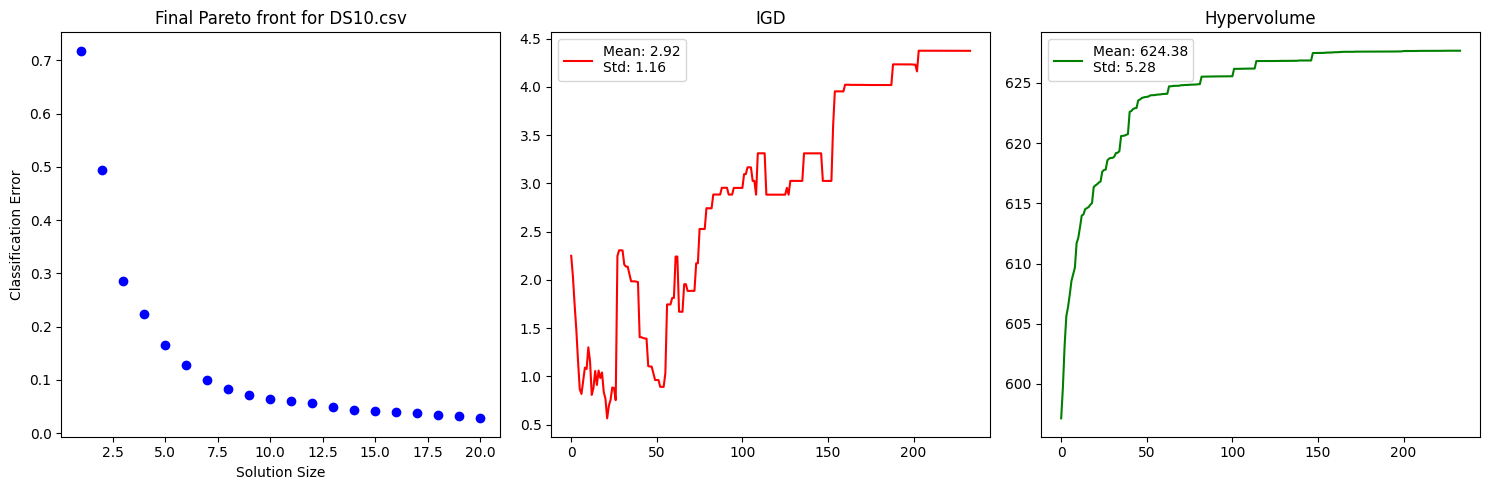

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS10.csv  |           191 |   621.531 |  7.30687 |    3.01139 |  0.646355 |         58 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS10.csv  |           234 |   624.376 |  5.27769 |    2.92048 |  1.1579   |         70 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [23]:
# wise initialization run 5
run_different_dataset(datasets[5])
doc = Document(document_path)
data = list(zip([datasets[5]]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)

print(table)
doc.save(document_path)